**Комментарий ревьюера**

Станислав, привет! Меня зовут Сергей Волков, я буду проверять твой проект. Если не против, давай общаться на «ты». Если это неудобно, дай знать, перейдем на «вы».

У тебя уже проделана большая работа над проектом, но давай сделаем его еще лучше. Дальше ты найдешь мои комментарии — пожалуйста, не перемещай и не удаляй их. Буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>  ❌красный текст - так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⚠️оранжевый текст - есть рекомендации, на что стоит обратить внимание. Так выделены небольшие замечания. Одно-два таких замечания в проекте допустимы, но если их будет больше - тебе будет необходимо внести исправления. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера:</b> ✔️зеленый текст - все отлично.</div>

Давай работать над проектом в диалоге: если что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 

<div class="alert alert-success">
<b>Комментарий ревьюера v.2:</b> ✔️Станислав, привет. Повторные комментарии отмечены v.2 </div>

# Разработка модели для  оценки ДТП по выбранному маршруту движения.

**Цель:**  
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.  

**Условия:**
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП. 

**Основные вопросы от заказчика:**
- Возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.  
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Импорт библиотек и подготовка окружения

In [1]:
import math
import pandas as pd
import random
import numpy as np
import seaborn as sns
import scipy.stats as st
from sqlalchemy import create_engine
from matplotlib import pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)

# Зафиксируем random seed
random.seed(0)
np.random.seed(0)

<div class="alert alert-info"> <b>Комментарий студента:</b> Привет! Заранее прошу прозения, что некоторые моменты сделаны не очень аккуратно, например отсутсвуют названия на некторых графиках или комментарии к коду. Дело в том, что у нас по учебе дедлайн 9-го числа, и просто все делаю в дикой спешке🤪 Однако, несмотря на это, по содержательной части и с точки зрения решения задачи, постарался выложиться по максимуму, насколько позволило время. Спасибо за понимание. Буду рад твоим комментариям 🙂</div>


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️ Спасибо, за комментарий, буду смотреть суть проекта, но как будет время проект нужно будет привести в соответствие!)</div>

<div class="alert alert-danger">
<b>Комментарий ревьюера :</b> Добавь пожалуйста название и цель проекта. </div>


<div class="alert alert-info"> <b>Комментарий студента:</b> Реди:)</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v.2:</b> ✔️👍 </div>

## 1. Подключение к базе. Загрузка таблиц sql

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

## 2. Первичное исследование таблиц

Посмотрим, какие таблицы присутвуют в нашей базе данных.

In [3]:
q = '''SELECT schemaname, relname
       FROM pg_stat_user_tables 
'''
pd.read_sql_query(q, con=engine)

,schemaname,relname
0,public,case_ids
1,public,parties
2,public,collisions
3,public,vehicles


В базе данных содержатся 4 таблицы: `case_ids`, `vehicles`, `collisions`, `parties`.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Отлично, у нас не всегда есть "архитектура" базы, а так мы можем узнать какие таблицы есть в распоряжении. </div>

### 1.1 Таблица `case_ids`

In [4]:
query_case_ids = '''SELECT *
                    FROM case_ids
                 '''
case_ids = pd.read_sql_query(query_case_ids, con=engine)

In [5]:
# Посмотрим на первичный и вторичные ключи таблицы
q = '''SELECT table_name, constraint_name, column_name, position_in_unique_constraint
       FROM INFORMATION_SCHEMA.KEY_COLUMN_USAGE
       WHERE table_name = 'case_ids'
'''
pd.read_sql_query(q, con=engine)

,table_name,constraint_name,column_name,position_in_unique_constraint
0,case_ids,case_ids_pk,case_id,None


In [6]:
# Посмотрим информацию о таблице
case_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


In [7]:
# Выведем количество уникальных значений столбцов таблицы
case_ids.nunique()

case_id    1400000
db_year          1
dtype: int64

In [8]:
# Посмотрим на значения столбца "db_year"
case_ids.db_year.unique()

array(['2021'], dtype=object)

In [9]:
# Выведем первые строки таблицы "case_ids"
case_ids.head(2)

,case_id,db_year
0,0081715,2021
1,0726202,2021


In [10]:
del case_ids

**Краткое резюме**  
- Таблица `case_ids` содержит год иницидента и уникальный ключ - "case_id".
- Всего в таблице 1400000 строк. Пропуски отсутствуют.
- Год выгрузки - 2021 год.

### 1.2 Таблица `vehicles`

In [11]:
query_vehicles = '''SELECT *
                    FROM vehicles
                 '''
vehicles = pd.read_sql_query(query_vehicles, con=engine)

In [12]:
# Посмотрим на первичный и вторичные ключи таблицы "vehicles"
q = '''SELECT table_name, constraint_name, column_name, position_in_unique_constraint
       FROM INFORMATION_SCHEMA.KEY_COLUMN_USAGE
       WHERE table_name = 'vehicles'
'''
pd.read_sql_query(q, con=engine)

,table_name,constraint_name,column_name,position_in_unique_constraint
0,vehicles,vehicles_pk,id,NaN
1,vehicles,vehicles_case_ids_case_id_fk,case_id,1.0


In [13]:
# Посмотрим информацию о таблице "vehicles"
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


In [14]:
# Выведем количество уникальных значений столбцов таблицы "vehicles"
vehicles.nunique()

id                      1021234
case_id                  792642
party_number                 27
vehicle_type                  5
vehicle_transmission          2
vehicle_age                  22
dtype: int64

In [15]:
# Выведем первые строки таблицы "vehicles"
vehicles.head(2)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0


In [16]:
del vehicles

**Краткое резюме**  
- Таблица `vehicles` содержит 6 столбцов.
- Всего в таблице 1021234 строк. Пропуски содержатся в столбцах `vehicle_transmission` и `vehicle_age`.

### 1.3 Таблица `collisions`

In [17]:
query_collisions = '''SELECT *
                      FROM collisions
                   '''
collisions = pd.read_sql_query(query_collisions, con=engine)

In [18]:
# Посмотрим на первичный и вторичные ключи таблицы "collisions"
q = '''SELECT table_name, constraint_name, column_name, position_in_unique_constraint
       FROM INFORMATION_SCHEMA.KEY_COLUMN_USAGE
       WHERE table_name = 'collisions'
'''
pd.read_sql_query(q, con=engine)

,table_name,constraint_name,column_name,position_in_unique_constraint
0,collisions,collisions_case_ids_case_id_fk,case_id,1


In [19]:
# Посмотрим информацию о таблице "collisions"
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

In [20]:
# Выведем количество уникальных значений столбцов таблицы "collisions"
collisions.nunique()

case_id                        1400000
county_city_location               538
county_location                     58
distance                          5071
direction                            4
intersection                         2
weather_1                            7
location_type                        3
collision_damage                     5
party_count                         18
primary_collision_factor             5
pcf_violation_category              23
type_of_collision                    7
motor_vehicle_involved_with          9
road_surface                         4
road_condition_1                     8
lighting                             5
control_device                       4
collision_date                    1550
collision_time                    1440
dtype: int64

In [21]:
# Выведем первые строки таблицы "collisions"
collisions.head(2)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00


In [22]:
del collisions

**Краткое резюме**  
- Таблица `collisions` содержит 1 внешний ключ - "case_id". Для данной таблицы, его можно считать также первичным.
- Таблица содержит 20 столбцов.
- Всего в таблице 1400000 строк. 
- Пропуски содержатся в 13-и столбцах: `direction`, `intersection`, `weather_1`, `location_type`, `primary_collision_factor`, `pcf_violation_category`, `type_of_collision`, `motor_vehicle_involved_with`, `road_surface`, `road_condition_1`, `lighting`, `control_device`, `collision_time`.

### 1.4 Таблица `parties`

In [23]:
# Нет возможности загрузить данную таблицу полностью, поэтому посмотрим лишь основную информацию о ней
count_rows_parties = '''SELECT COUNT(*)
                        FROM parties
                        LIMIT 10
                     '''

sample_parties = '''SELECT *
                    FROM parties
                    LIMIT 10
                 '''

count_rows = pd.read_sql_query(count_rows_parties, con=engine)
parties_sample = pd.read_sql_query(sample_parties, con=engine)

print(f'Shape of "parties": {count_rows.values[0][0]} rows and {parties_sample.shape[1]} columns')

Shape of "parties": 2752408 rows and 9 columns



<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️ Отлично, если таблица содержит слишком много данных, её можно ограничить.  </div>

In [24]:
# Посмотрим на первичный и вторичные ключи таблицы "parties"
q = '''SELECT table_name, constraint_name, column_name, position_in_unique_constraint
       FROM INFORMATION_SCHEMA.KEY_COLUMN_USAGE
       WHERE table_name = 'parties'
'''
pd.read_sql_query(q, con=engine)

,table_name,constraint_name,column_name,position_in_unique_constraint
0,parties,parties_pk,id,NaN
1,parties,parties_case_ids_case_id_fk,case_id,1.0


In [25]:
# Выведем первые строки таблицы "parties"
parties_sample.head(2)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0


**Краткое резюме**  
- Таблица `parties` содержит 1 первичный ключ, и 1 внешний ключ - "case_id".
- Таблица содержит 9 столбцов.
- Всего в таблице 2752408  строк. 

### Резюме

- В базе данных содержится 4 таблицы: `case_ids`, `vehicles`, `collisions`, `parties`. Их количество соответсвует условию задачи.
- Все таблицы имеют 1 общий ключ для связи - `case_id`
- Все таблицы имеют наборы данных.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Хорошо, данные загружены, есть первичная аналитическая информация. </div>

##  3. Статистический анализ факторов ДТП

### 3.1 Анализ зависимости количества аварий от месяца ДТП

Посмотрим на первые пять строк таблицы `collisions`

In [26]:
query_collisions = '''SELECT *
                      FROM collisions
                      LIMIT 5
                   '''

pd.read_sql_query(query_collisions, con=engine)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Посмотрим, какое количество ДТП было зафиксировано по годам:

In [27]:
query_collisions = '''SELECT EXTRACT('year' FROM collision_date) year_of_collision,
                             COUNT(*)
                      FROM collisions
                      GROUP BY EXTRACT('year' FROM collision_date)
                   '''
print(pd.read_sql_query(query_collisions, con=engine))

   year_of_collision   count
0             2009.0  426228
1             2010.0  416490
2             2011.0  402428
3             2012.0  154547
4             2013.0     305
5             2020.0       2


Посмотрим на количество ДТП внутри каждого года по месяцам.

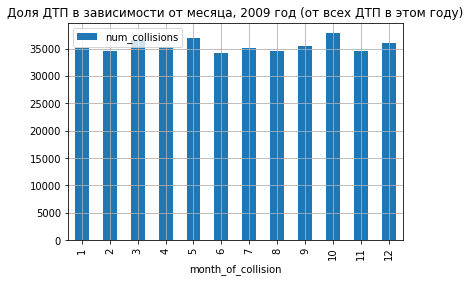

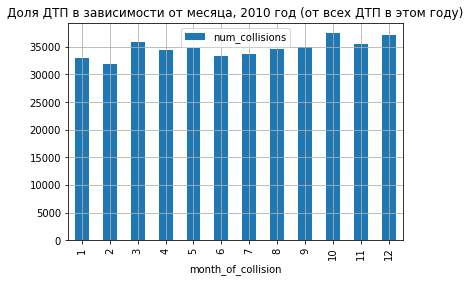

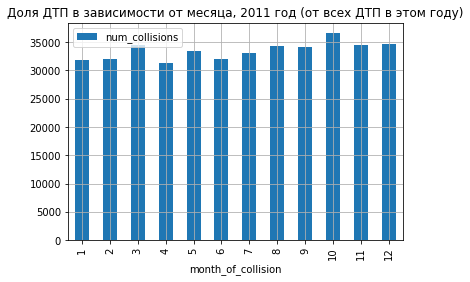

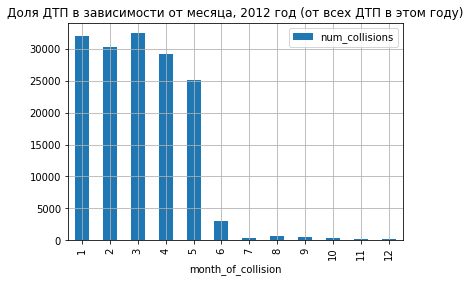

In [28]:
for year in [2009, 2010, 2011, 2012]:
    query_collisions = f'''SELECT EXTRACT('month' FROM collision_date)::int AS month_of_collision,
                             COUNT(*) AS num_collisions
                          FROM collisions
                          WHERE EXTRACT('year' FROM collision_date) = {year}
                          GROUP BY EXTRACT('month' FROM collision_date)
                       '''
    pd.read_sql_query(query_collisions, con=engine, index_col='month_of_collision').plot.bar(grid=True)
    plt.title(f"Доля ДТП в зависимости от месяца, {year} год (от всех ДТП в этом году)");
    plt.show();

В среднем, в течение года наблюдается примерно одинаковое количество ДТП. Из месяцев, в которые количество происшествий чуть превышало среднее, можно выделить: март, октябрь, ноябрь, декабрь.   
В данных за 2012 год зафиксировано аномально низкое количество происшествий начиная с июня месяца. Сложно сказать, с чем это связано, но похоже на аномалию.  
Данные за 2013 и 2020 год не входили в анализ по причине недостаточности наблюдений.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Отлично, вот это интересный момент, если бы вывели просто инфорацию по месяцам, то получили бы картину, что с 1 по 6 месяц больше все ДТП, а так есть понимание, что по какой-то пичине начиная с июня 2012 года у нас идет резкое падение кол-ва случаев ДТП. Но пока нет ответа почему так произошло. </div>

### 3.2  Постановка задач для коллег

1. Изучите, влияют ли погодные условия на количество дорожно-транспортных происшествий? (таблица `collisions`)
2. Проведите анализ серьезности повреждений исходя из погодных условия на дороге в момент происшествия.
3. Проанализирйте, влияет ли уровень освещения на количество происшествий, а также на серьезность повреждения транспортного средства? (таблица `collisions`)
4. Проведите анализ и выясните, влияет ли возраст траспортного средства на тип аварии (таблицы `collisions` и `vehicles`)

    Для этого:  
    - Создайте SQL-запрос
    - Сгруппируйте данные по типу аварии и выведите средний и медианный возраст для каждого типа
    - Отобразите получившийся результат на графике (например, можно использовать "barplot")
    - Сделайте вывод
    
    
5. Проанализируйте, влияет ли тип кузова траспортного средства на серьезность повреждения (`collisions` и `vehicles`)  

    Для этого:  
    - Создайте SQL-запрос
    - Сгруппируйте данные по типу кузова. Для каждого типа посчитайте сколько раз встречалась та или иная категория повреждения
    - Для удобства, распределение частоты встречаемости той или иной категории повреждения можно визуализировать на графике (для каждого типа кузова отдельный график)
    - Сделайте вывод
    

6. Выясните, есть ли зависимость количества ДТП от физического состояния участников, а также влияет ли это состояние на серьезность повреждения транспортного средства? (таблицы `collisions` и `parties`)


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Хорошо, цели сформированы, в целом всё отлично. Вопрос по 6 пункту, мы понимае, что ДТП часто это антропогенный случай, но мы не знаем на момент, когда садится потенциальный водитель за руль в каком он состоянии, поэтому можно добавить ещё как вариант возраст и пол водителя, может быть при определенных условиях эти факторы влияют. И уточнение по 5 пункту, тип кузова это тип транспортного средства или именно седан, хэтчбек и тд.  </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> По поводу возраста и пола согласен, но их у нас нет к сожалению. А по поводу типа, да, имелось ввиду тип кузова (седан, хетчбэк и тд) </div>

## 4. Создание модели для оценки водительского риска

Исходя из формулировки задачи заказчиком - мы хотим предсказать, будет ли авто являться виновником ДТП или нет.

Создадим запрос и загрузим необходимые данные в датафрейм.

In [29]:
q = '''SELECT p.case_id, p.party_number, p.party_type, p.at_fault, p.party_sobriety, p.party_drug_physical, p.cellphone_in_use,
              c.county_city_location, c.county_location, c.distance, c.direction, c.intersection, c.weather_1, c.location_type, 
              c.collision_damage, c.party_count, c.primary_collision_factor, c.pcf_violation_category, c.type_of_collision, 
              c.motor_vehicle_involved_with, c.road_surface, c.road_condition_1, c.lighting, c.control_device, c.collision_date, 
              c.collision_time, v.vehicle_type, v.vehicle_transmission, v.vehicle_age
       FROM parties p
       LEFT JOIN collisions c ON p.case_id = c.case_id
       LEFT JOIN vehicles v ON (v.case_id = p.case_id AND v.party_number = p.party_number)
       WHERE p.party_type = 'car' 
             AND c.collision_damage <> 'scratch' 
             AND EXTRACT('year' FROM c.collision_date) = 2012
'''
data_from_query = pd.read_sql_query(q, con=engine, parse_dates=['collision_date'])

In [30]:
data_from_query.head()

,case_id,party_number,party_type,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,5527313,5,car,0,had not been drinking,None,0.0,1964,los angeles,1584.0,south,0.0,cloudy,highway,small damage,5,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-03-16,16:55:00,sedan,manual,1.0
1,5488102,5,car,1,had not been drinking,None,0.0,0792,contra costa,1700.0,west,0.0,clear,highway,small damage,6,vehicle code violation,speeding,rear end,other motor vehicle,None,normal,dark with no street lights,none,2012-02-16,18:20:00,None,None,NaN
2,5457635,5,car,0,had not been drinking,None,0.0,1954,los angeles,900.0,north,0.0,clear,highway,small damage,7,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-19,08:25:00,None,None,NaN
3,5491000,5,car,0,impairment unknown,G,0.0,1954,los angeles,100.0,north,0.0,clear,highway,small damage,5,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-02-02,09:30:00,None,None,NaN
4,5496532,5,car,0,had not been drinking,None,0.0,1900,los angeles,200.0,south,0.0,clear,None,middle damage,5,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2012-02-04,12:50:00,None,None,NaN


In [31]:
data_from_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   case_id                      196837 non-null  object        
 1   party_number                 196837 non-null  int64         
 2   party_type                   196837 non-null  object        
 3   at_fault                     196837 non-null  int64         
 4   party_sobriety               193212 non-null  object        
 5   party_drug_physical          25148 non-null   object        
 6   cellphone_in_use             171464 non-null  float64       
 7   county_city_location         196837 non-null  object        
 8   county_location              196837 non-null  object        
 9   distance                     196837 non-null  float64       
 10  direction                    153975 non-null  object        
 11  intersection              

Произведем отбор признаков:

In [32]:
features = [     
            'party_sobriety', # Трезвость участника, может иметь влияние. Таблица "parties"
            
            'party_drug_physical', # Состояние физическое или с учетом принятых лекарств, может иметь влияние. 
                                   # Таблица "parties"
            
            'cellphone_in_use', # Наличие возможности говорит по грмокой связи, не факт что ей пользовались, но влиять может. 
                                # Таблица "collisions"
            
            'distance', # Расстояние от главное дороги, может пригодиться на этапе планирования маршрута. Таблица "collisions"
            
            'intersection', # Является ли место ДТП перекрестком, может коррелировать с "location_type".  
                            # В крайнем случае, используем для заполнения пропусков. Таблица "collisions"
            
            'location_type', # Тип дороги. Таблица "collisions"
            
            'weather_1', # Погодные условия, могут влиять однозначно. Таблица "collisions"
            
            'road_surface', # Состояние дороги, из минусов - может быть сложно получить информацию по данному типу состояния. 
                            # Таблица "collisions"
            
            'road_condition_1', # Состояние дороги 2, по этому состоянию получить информаию может быть проще. 
                                # Таблица "collisions"
            
            'lighting', # Освещения, может влиять. Таблица "collisions"
            
            'control_device', # Состояние устройства управления. Хотелось бы узнать, что конкретно означает этот признак,
                              # но похоже на какую-то техническую характеристику авто. Таблица "collisions"
            
            'collision_time', # Время происшествия. Может влиять, так как в определенные часы на дорогах
                              # может быть больше либо меньше машин. Таблица "collisions"
            
            'vehicle_type', # Тип кузова. Гипотетически, водители, которые выбирают автомобили разных кузовов 
                            # могут отличаться по характеру вождения. Таблица "vehicles"
            
            'vehicle_transmission', # Тип КПП, маловероятно, что как-то влияет, но проверить стоит. Таблица "vehicles"
            
            'vehicle_age', # Возраст автомобиля, может влиять. Таблица "vehicles"
            
            'at_fault' # Целевой признак. Таблица "parties"
]

In [33]:
data_eda = data_from_query[features]

Небольшое обоснование, почему некоторые признаки были отброшены из дальнейшего анализа.  
- `collision_date` использовать не будем, так как данные по месяцам распределены не равномерно. После июня данные практически отсутсвуют. Время года как правило может влиять на освещение, погодные условия и состояние дороги. Эти признаки сохранятся в датасете.  
- `direction` также не вошел в число исследуемых признаков. Зависимость направления движения и того, что с водителем может произойти в то время как он будет ехать в этом направлении сильно может зависеть от населенного пункта. Поэтому, даже если и однаружится какая либо корреляция с этим признаком, вряли можно говорить о том, что этот признак будет указывать на "причинность". Этот тот случай, про который можно сказать "correlation doesn't mean causation". Следовательно не имеет смысла изучать корреляцию целевого показателя с данным признаком.  
- `collision_damage`, `primary_collision_factor`, `pcf_violation_category`, `type_of_collision`, `motor_vehicle_involved_with`, `party_count` не вошли в список признаков, так как относятся к тому, что можно узнать после аварии, а не на до происшествия.
- `county_location`, `county_city_location` - если мы используем эти признаки, то нам может быть сложно обобщить результаты модели на районы, в которых ДТП зарегестрированы не были, но потенциально могут быть. Эти признаки скорее всего не являются первопричиной.
- `party_type` - имеет едитсвенное значения для всех объектов и был взят лишь в качестве фильтра для запроса.



<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️В целом всё отлично, добавил бы признаки, про которые писал ранее, возраст водителя и пол водителя, но с другой стороны это твоё видение задачи)
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Так у нас же нет этих признаков в данных :) А так бы я их с удовольствием добабвил бы) </div>

### 4.1 Краткий исследовательский анализ данных

In [34]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   party_sobriety        193212 non-null  object 
 1   party_drug_physical   25148 non-null   object 
 2   cellphone_in_use      171464 non-null  float64
 3   distance              196837 non-null  float64
 4   intersection          195850 non-null  float64
 5   location_type         87357 non-null   object 
 6   weather_1             196183 non-null  object 
 7   road_surface          195564 non-null  object 
 8   road_condition_1      195694 non-null  object 
 9   lighting              196116 non-null  object 
 10  control_device        195864 non-null  object 
 11  collision_time        195464 non-null  object 
 12  vehicle_type          56248 non-null   object 
 13  vehicle_transmission  55389 non-null   object 
 14  vehicle_age           54554 non-null   float64
 15  

Округлим `collision_time` до часов.

In [35]:
def extract_hour(datetime_value):
    try:
        hour = [datetime_value.hour if datetime_value.minute <= 30 else datetime_value.hour + 1][0]
        return hour
    except:
        return np.nan

In [36]:
data_eda['collision_time'] = data_eda['collision_time'].apply(extract_hour)

Посмотрим на категориальные данные.

In [37]:
data_eda.select_dtypes('object').nunique()

party_sobriety          6
party_drug_physical     5
location_type           3
weather_1               7
road_surface            4
road_condition_1        8
lighting                5
control_device          4
vehicle_type            3
vehicle_transmission    2
dtype: int64

In [38]:
for idx, col in enumerate(data_eda.select_dtypes('object').columns):
    print(idx, '-', col)
    print(list(data_eda[col].unique()))
    print('-'*10)

0 - party_sobriety
['had not been drinking', 'impairment unknown', 'not applicable', None, 'had been drinking, not under influence', 'had been drinking, under influence', 'had been drinking, impairment unknown']
----------
1 - party_drug_physical
[None, 'G', 'not applicable', 'sleepy/fatigued', 'impairment - physical', 'under drug influence']
----------
2 - location_type
['highway', None, 'ramp', 'intersection']
----------
3 - weather_1
['cloudy', 'clear', 'raining', 'fog', None, 'snowing', 'other', 'wind']
----------
4 - road_surface
['dry', None, 'wet', 'snowy', 'slippery']
----------
5 - road_condition_1
['normal', 'construction', None, 'obstruction', 'holes', 'other', 'loose material', 'flooded', 'reduced width']
----------
6 - lighting
['daylight', 'dark with no street lights', 'dark with street lights', 'dusk or dawn', None, 'dark with street lights not functioning']
----------
7 - control_device
['none', 'functioning', None, 'not functioning', 'obscured']
----------
8 - vehicle_

Исследуем каждый признак индивидуально.

### Категориальные признаки

#### 4.1.1 Признак `party_sobriety`      

In [39]:
print('Количество пропусков', data_eda['party_sobriety'].isna().sum())
data_eda['party_sobriety'].value_counts()

Количество пропусков 3625


had not been drinking                     157684
impairment unknown                         20525
had been drinking, under influence         10270
had been drinking, impairment unknown       1706
not applicable                              1674
had been drinking, not under influence      1353
Name: party_sobriety, dtype: int64

In [40]:
# Заполним пропуски
data_eda['party_sobriety'] = data_eda['party_sobriety'].fillna('unknown')

# Заменим значение 'not applicable' на 'unknown', так как они эквивалентны
data_eda['party_sobriety'] = data_eda['party_sobriety'].mask(data_eda['party_sobriety'] == 'not applicable', 'unknown')

print('Пропусков после заполнения:', data_eda['party_sobriety'].isna().sum())
data_eda['party_sobriety'].value_counts()

Пропусков после заполнения: 0


had not been drinking                     157684
impairment unknown                         20525
had been drinking, under influence         10270
unknown                                     5299
had been drinking, impairment unknown       1706
had been drinking, not under influence      1353
Name: party_sobriety, dtype: int64

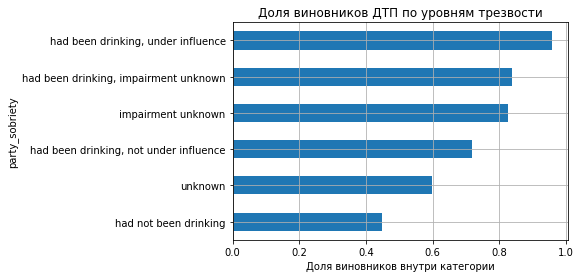

In [41]:
data_eda.groupby('party_sobriety')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников внутри категории')
plt.title('Доля виновников ДТП по уровням трезвости');

**Резюме:**  
Как и следовало ожидать, те, кто употреблял алкоголь являлись виновниками чаще, чем те, кто его не употреблял. 

#### 4.1.2 Признак `party_drug_physical` 

In [42]:
print('Количество пропусков', data_eda['party_drug_physical'].isna().sum())
data_eda['party_drug_physical'].value_counts()

Количество пропусков 171689


G                        20525
not applicable            1674
under drug influence      1516
sleepy/fatigued           1096
impairment - physical      337
Name: party_drug_physical, dtype: int64

In [43]:
# Заполним пропуски
data_eda['party_drug_physical'] = data_eda['party_drug_physical'].fillna('unknown')

# Заменим значение 'G' и 'not applicable' на 'unknown', так как они эквивалентны
data_eda['party_drug_physical'] = data_eda['party_drug_physical'].mask(data_eda['party_drug_physical'] == 'G', 'unknown')
data_eda['party_drug_physical'] = data_eda['party_drug_physical'].mask(data_eda['party_drug_physical'] == 'not applicable', 'unknown')

print('Пропусков после заполнения:', data_eda['party_drug_physical'].isna().sum())
data_eda['party_drug_physical'].value_counts()

Пропусков после заполнения: 0


unknown                  193888
under drug influence       1516
sleepy/fatigued            1096
impairment - physical       337
Name: party_drug_physical, dtype: int64

Посмотрим, какая категория лиц чаще всего являлась виновником аварии.

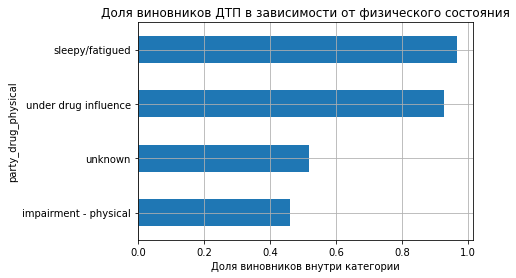

In [44]:
data_eda.groupby('party_drug_physical')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников внутри категории')
plt.title('Доля виновников ДТП в зависимости от физического состояния');

**Резюме:**  
Те, кто был уставшим либо под воздействием лекарств чаще являлись виновниками ДТП, нежели те, у кого наблюдалась физическая усталость.

#### 4.1.3 Признак `location_type`       

In [45]:
print('Количество пропусков', data_eda['location_type'].isna().sum())
data_eda['location_type'].value_counts()

Количество пропусков 109480


highway         71914
ramp            11526
intersection     3917
Name: location_type, dtype: int64

In [46]:
# Заполним пропуски
data_eda['location_type'] = data_eda['location_type'].fillna('unknown')

print('Пропусков после заполнения:', data_eda['location_type'].isna().sum())
data_eda['location_type'].value_counts()

Пропусков после заполнения: 0


unknown         109480
highway          71914
ramp             11526
intersection      3917
Name: location_type, dtype: int64

Посмотрим, при движении по какой дороге водитель чаще всего был виновником происшествия.

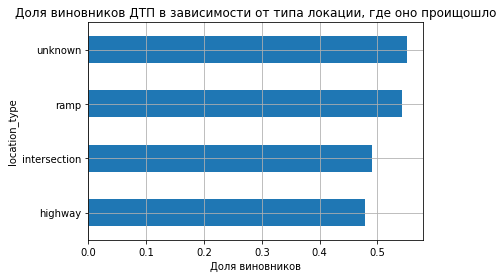

In [47]:
data_eda.groupby('location_type')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от типа локации, где оно проищошло');

Посмотрим, где чаще всего происходили ДТП:

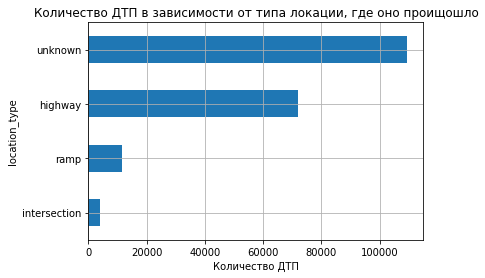

In [48]:
data_eda.groupby('location_type')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от типа локации, где оно проищошло');

Посмотрим, в каком соотношении распределено количество ДТП на разных участках дороги:

In [49]:
data_eda['location_type'][lambda x: x != 'unknown'].value_counts(normalize=True) * 100

highway         82.321966
ramp            13.194134
intersection     4.483899
Name: location_type, dtype: float64

**Резюме:**  
На шоссе происходило значительно больше аварий, нежели на других участках дороги.  
Однако, данный признак не поможет нам в построении предсказательной модели, так как мы предсказываем будет ли водитель виновникам аварии или нет. В то время как признак `location_type` не влиет на факт вины водителя, а влияет на сам факт случившегося происшествия.  

Таким образом, можно разделить предсказание на две части: вероятность того, что авария произойдет (это показатель будет зависеть от маршрута) и вероятность того, что водительбудет виновником ДТП (это то, что мы можем попытаться предсказать, основываясь на признаках, которые непосредсвенно относятся к автомобилю).  
Однако, достаточно непросто использовать эту информацию. Если мы возьмем аварию, и примем частоту аварий на определенных участках дороги за вероятности, то мы сможем утверждать, что с вероятностью 82% случайно взятая авария произошла на шоссе. Однако это не дает нам право брать случайный автомобиль, движущися по шоссе и утверждать с какой-либо вероятностью, что этот автомобиль попадет в аварию. Для этого, нам неободимо обладать общей статистикой по количеству автомобилей, проезжавших по шоссе за год, и тогда, найдя долю тех, кто попал в аварию, можно делать предположения о такой вероятности.  
Данный признак не берем для дальнейшего анализа.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Возможно для полноты картины можно сопаставить еще со временем суток. </div>

#### 4.1.4 Признак `weather_1`           

In [50]:
print('Количество пропусков', data_eda['weather_1'].isna().sum())
data_eda['weather_1'].value_counts()

Количество пропусков 654


clear      157335
cloudy      29497
raining      8112
fog           584
snowing       433
other         175
wind           47
Name: weather_1, dtype: int64

In [51]:
# Заполним пропуски
data_eda['weather_1'] = data_eda['weather_1'].fillna('unknown')

# Заменим значение 'other' на 'unknown', так как они эквивалентны
data_eda['weather_1'] = data_eda['weather_1'].mask(data_eda['weather_1'] == 'other', 'unknown')

print('Пропусков после заполнения:', data_eda['weather_1'].isna().sum())
data_eda['weather_1'].value_counts()

Пропусков после заполнения: 0


clear      157335
cloudy      29497
raining      8112
unknown       829
fog           584
snowing       433
wind           47
Name: weather_1, dtype: int64

Посмотрим, при какой погоде водитель чаще всего был виновником происшествия.

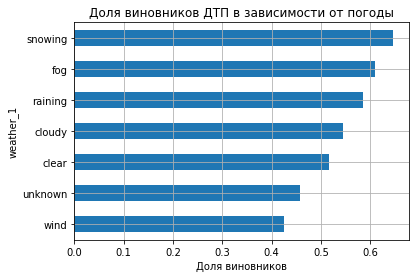

In [52]:
data_eda.groupby('weather_1')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от погоды');

Посмотрим, в какую погоду чаще всего происходили ДТП:

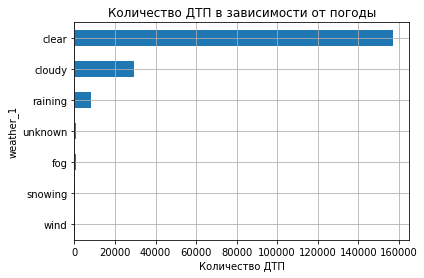

In [53]:
data_eda.groupby('weather_1')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от погоды');

**Резюме:**  
В снежную погоду, водители чаще всего были виновниками аварии, нежели в ясную погоду. При этом, больше всего аварий по количеству в целом произошло в ясную погоду.  
Хоть разница и незначительна, но возможно, этот признак стоит оставить.

#### 4.1.5 Признак `road_surface`        

In [54]:
print('Количество пропусков', data_eda['road_surface'].isna().sum())
data_eda['road_surface'].value_counts()

Количество пропусков 1273


dry         175564
wet          18920
snowy          926
slippery       154
Name: road_surface, dtype: int64

In [55]:
# Заполним пропуски
data_eda['road_surface'] = data_eda['road_surface'].fillna('unknown')

print('Пропусков после заполнения:', data_eda['road_surface'].isna().sum())
data_eda['road_surface'].value_counts()

Пропусков после заполнения: 0


dry         175564
wet          18920
unknown       1273
snowy          926
slippery       154
Name: road_surface, dtype: int64

Посмотрим, при каком состоянии дороги водитель чаще всего был виновником происшествия.

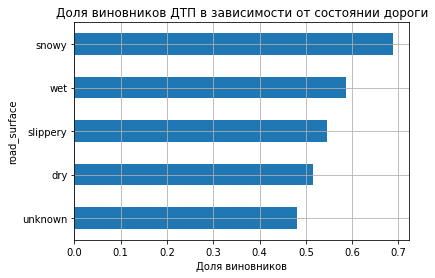

In [56]:
data_eda.groupby('road_surface')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от состоянии дороги');

Посмотрим, при каком состоянии дороги чаще всего происходили ДТП:

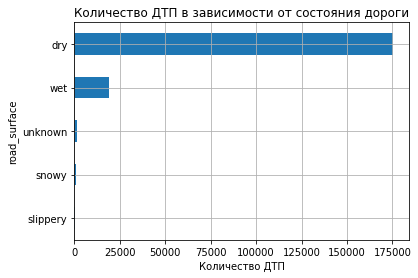

In [57]:
data_eda.groupby('road_surface')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от состояния дороги');

**Резюме:**  
При заснеженной дороге, водители чаще всего были виновниками аварии, нежели при езде по сухой дороге. При этом, больше всего аварий по количеству в целом произошло на сухой дороге.  
Чего стоит опасаться: может быть корреляция с погодными условиями. Более того, достаточно сложно может на практикие оказаться измерение этого признака в режиме реального времени.  
Этот признак отбросим.

#### 4.1.6 Признак `road_condition_1`    

In [58]:
print('Количество пропусков', data_eda['road_condition_1'].isna().sum())
data_eda['road_condition_1'].value_counts()

Количество пропусков 1143


normal            189563
construction        3355
other                789
obstruction          729
holes                626
loose material       310
reduced width        217
flooded              105
Name: road_condition_1, dtype: int64

In [59]:
# Заполним пропуски
data_eda['road_condition_1'] = data_eda['road_condition_1'].fillna('unknown')

# Заменим значение 'other' на 'unknown', так как они эквивалентны
data_eda['road_condition_1'] = data_eda['road_condition_1'].mask(data_eda['road_condition_1'] == 'other', 'unknown')

print('Пропусков после заполнения:', data_eda['road_condition_1'].isna().sum())
data_eda['road_condition_1'].value_counts()

Пропусков после заполнения: 0


normal            189563
construction        3355
unknown             1932
obstruction          729
holes                626
loose material       310
reduced width        217
flooded              105
Name: road_condition_1, dtype: int64

Посмотрим, при каком состоянии дороги водитель чаще всего был виновником происшествия.

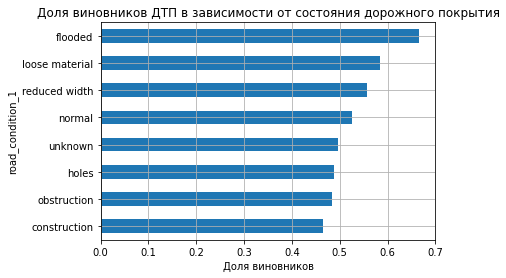

In [60]:
data_eda.groupby('road_condition_1')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от состояния дорожного покрытия');

Посмотрим, при каком состоянии дороги чаще всего происходили ДТП:

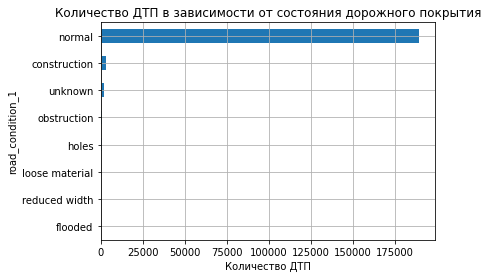

In [61]:
data_eda.groupby('road_condition_1')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от состояния дорожного покрытия');

**Резюме:**  
При езде по затопленной дороге, водители чаще всего были виновниками аварии. При этом, больше всего аварий по количеству в целом произошло на нормальной дороге.  
Этот признак можно взять для дальнейшего анализа.

#### 4.1.7 Признак `lighting`            

In [62]:
print('Количество пропусков', data_eda['lighting'].isna().sum())
data_eda['lighting'].value_counts()

Количество пропусков 721


daylight                                   136370
dark with street lights                     38095
dark with no street lights                  14430
dusk or dawn                                 6775
dark with street lights not functioning       446
Name: lighting, dtype: int64

In [63]:
# Заполним пропуски
data_eda['lighting'] = data_eda['lighting'].fillna('unknown')

print('Пропусков после заполнения:', data_eda['lighting'].isna().sum())
data_eda['lighting'].value_counts()

Пропусков после заполнения: 0


daylight                                   136370
dark with street lights                     38095
dark with no street lights                  14430
dusk or dawn                                 6775
unknown                                       721
dark with street lights not functioning       446
Name: lighting, dtype: int64

Посмотрим, при каком освещении дороги водитель чаще всего был виновником происшествия.

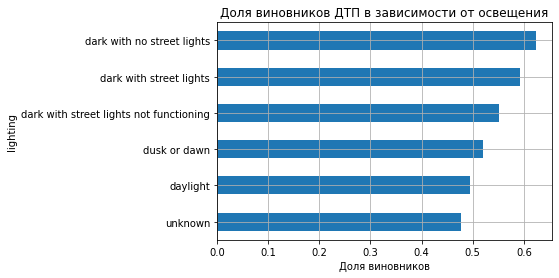

In [64]:
data_eda.groupby('lighting')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от освещения');

Посмотрим, при каком освещении чаще всего происходили ДТП:

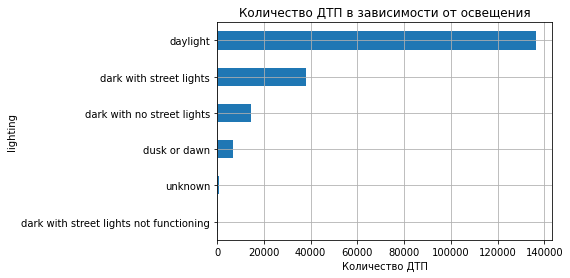

In [65]:
data_eda.groupby('lighting')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от освещения');

**Резюме:**  
Больше всего аварий проищошло при дневном освещении, однако виновниками этих аварий чаще всего являлись водители, которые ехали в темное время суток.   
Этот признак можно взять для дальнейшего анализа.

#### 4.1.8 Признак `control_device`      

In [66]:
print('Количество пропусков', data_eda['control_device'].isna().sum())
data_eda['control_device'].value_counts()

Количество пропусков 973


none               132665
functioning         62639
not functioning       444
obscured              116
Name: control_device, dtype: int64

In [67]:
# Заполним пропуски
data_eda['control_device'] = data_eda['control_device'].fillna('unknown')

# Заменим значение 'none' на 'unknown', так как они эквивалентны
data_eda['control_device'] = data_eda['control_device'].mask(data_eda['control_device'] == 'none', 'unknown')

print('Пропусков после заполнения:', data_eda['control_device'].isna().sum())
data_eda['control_device'].value_counts()

Пропусков после заполнения: 0


unknown            133638
functioning         62639
not functioning       444
obscured              116
Name: control_device, dtype: int64

Посмотрим, при каком состоянии устройства управления водитель чаще всего был виновником происшествия.

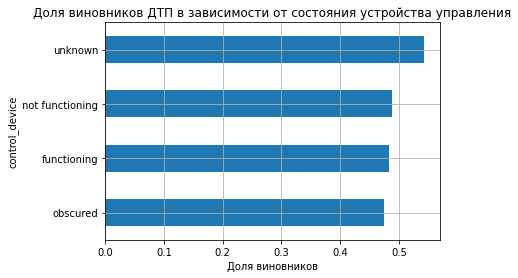

In [68]:
data_eda.groupby('control_device')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от состояния устройства управления');

Посмотрим, при каком состоянии устройства управления чаще всего происходили ДТП:

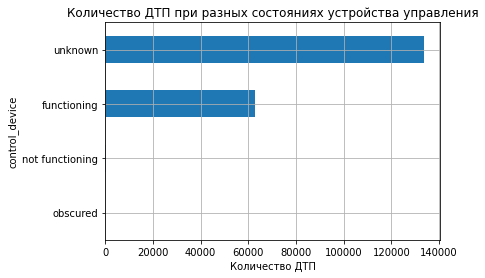

In [69]:
data_eda.groupby('control_device')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП при разных состояниях устройства управления');

**Резюме:**  
Доля виновников ДТП при различных состояниях управления практически одинакова. Данный признак можно исключить из дальнейшего анализа.

#### 4.1.9 Признак `vehicle_type`        

In [70]:
print('Количество пропусков', data_eda['vehicle_type'].isna().sum())
data_eda['vehicle_type'].value_counts()

Количество пропусков 140589


sedan    37180
coupe    19064
other        4
Name: vehicle_type, dtype: int64

In [71]:
# Заполним пропуски
data_eda['vehicle_type'] = data_eda['vehicle_type'].fillna('unknown')

# Заменим значение 'other' на 'unknown', так как они эквивалентны
data_eda['vehicle_type'] = data_eda['vehicle_type'].mask(data_eda['vehicle_type'] == 'other', 'unknown')

print('Пропусков после заполнения:', data_eda['vehicle_type'].isna().sum())
data_eda['vehicle_type'].value_counts()

Пропусков после заполнения: 0


unknown    140593
sedan       37180
coupe       19064
Name: vehicle_type, dtype: int64

Посмотрим, водители автомобилей с каким кузовом чаще всего были виновниками происшествия.

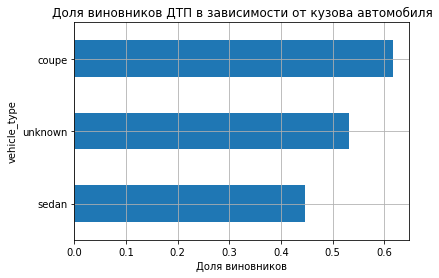

In [72]:
data_eda.groupby('vehicle_type')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от кузова автомобиля');

Посмотрим, автомобили с каким кузовом чаще всего происходили ДТП:

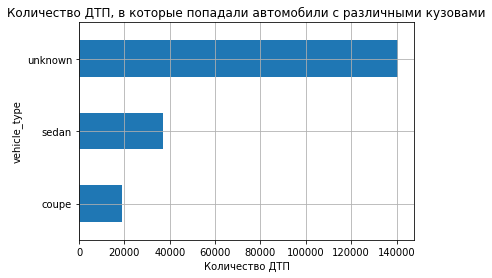

In [73]:
data_eda.groupby('vehicle_type')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП, в которые попадали автомобили с различными кузовами');

**Резюме:**  
Чаще всего виновниками аварий были водители автомобилей с типо кузова "купе".  Больше всего аварий же пришлось на авто с кузовом типа "седан".
Этот признак можно взять для дальнейшего анализа.

#### 4.1.10 Признак `collision_time`

In [74]:
print('Количество пропусков', data_eda['collision_time'].isna().sum())
data_eda['collision_time'].value_counts()

Количество пропусков 1373


15.0    15275
16.0    15035
17.0    15015
18.0    14742
8.0     13735
14.0    11777
13.0    11556
12.0    10491
19.0     9813
9.0      9779
11.0     8696
10.0     8523
7.0      7642
20.0     7025
21.0     6157
22.0     5205
23.0     4383
6.0      4179
2.0      3576
1.0      3021
3.0      2538
5.0      2065
0.0      1839
4.0      1805
24.0     1592
Name: collision_time, dtype: int64

In [75]:
# Заполним пропуски
data_eda['collision_time'] = data_eda['collision_time'].fillna(-1)

print('Пропусков после заполнения:', data_eda['collision_time'].isna().sum())
data_eda['collision_time'].value_counts()

Пропусков после заполнения: 0


 15.0    15275
 16.0    15035
 17.0    15015
 18.0    14742
 8.0     13735
 14.0    11777
 13.0    11556
 12.0    10491
 19.0     9813
 9.0      9779
 11.0     8696
 10.0     8523
 7.0      7642
 20.0     7025
 21.0     6157
 22.0     5205
 23.0     4383
 6.0      4179
 2.0      3576
 1.0      3021
 3.0      2538
 5.0      2065
 0.0      1839
 4.0      1805
 24.0     1592
-1.0      1373
Name: collision_time, dtype: int64

Посмотрим, в какое время суток водитель чаще всего был виновником происшествия.

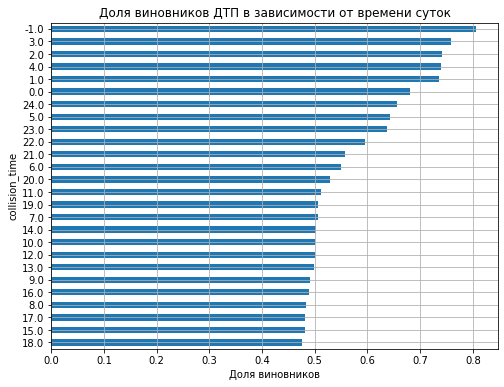

In [76]:
data_eda.groupby('collision_time')['at_fault'].mean().sort_values().plot.barh(grid=True, figsize=(8, 6));
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от времени суток');

Посмотрим, в какое время суток чаще всего происходили ДТП:

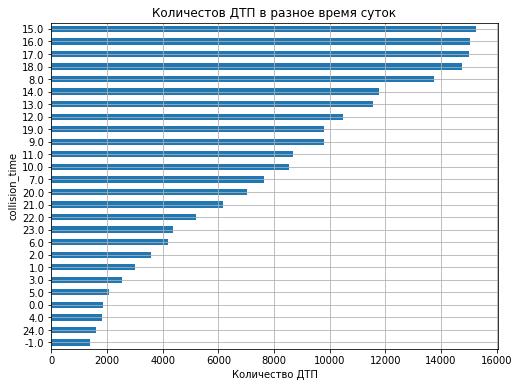

In [77]:
data_eda.groupby('collision_time')['at_fault'].count().sort_values().plot.barh(grid=True, figsize=(8, 6));
plt.xlabel('Количество ДТП')
plt.title('Количестов ДТП в разное время суток');

**Резюме:**  
Больше всего аварий произошло с 13 до 18 часов, однако виновниками этих аварий чаще всего являлись водители, которые ехали в в промежутке с часу до четырех часов утра.   
Этот признак можно взять для дальнейшего анализа.


<div class="alert alert-warning">
<b>Комментарий ревьюера :</b> В целом всё хорошо, описание выводы, можно только графики сделать более читаемыми и с размером поработать.</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Подправил.</div>

<div class="alert alert-success">
<b>Комментарий ревьюера v.2:</b> ✔️ Отлично, так информативней. </div>

### Бинарные признаки

#### 4.1.11 Признак `cellphone_in_use`

In [78]:
print('Количество пропусков', data_eda['cellphone_in_use'].isna().sum())
data_eda['cellphone_in_use'].value_counts()

Количество пропусков 25373


0.0    167412
1.0      4052
Name: cellphone_in_use, dtype: int64

In [79]:
# Заполним пропуски
data_eda['cellphone_in_use'] = data_eda['cellphone_in_use'].fillna(-1)

print('Пропусков после заполнения:', data_eda['cellphone_in_use'].isna().sum())
data_eda['cellphone_in_use'].value_counts()

Пропусков после заполнения: 0


 0.0    167412
-1.0     25373
 1.0      4052
Name: cellphone_in_use, dtype: int64

Посмотрим, как влияло наличие возможности разговаривать по громкой связи на факт вины водителя.

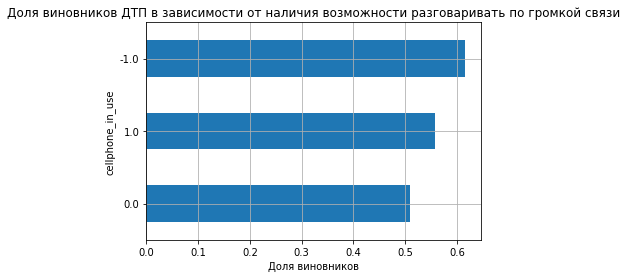

In [80]:
data_eda.groupby('cellphone_in_use')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от наличия возможности разговаривать по громкой связи');

Посмотрим, на количество автомобилей, с возможностью использовать громкую связь и без таковой, которые попадали в ДТП:

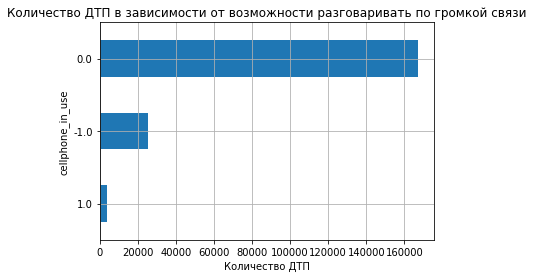

In [81]:
data_eda.groupby('cellphone_in_use')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от возможности разговаривать по громкой связи');

**Резюме:**  
Среди автомобилей, попавших в аварии, у большинства не было возможности разговаривать по громкой связи. При этом, доля виновников ДТП примерно одинакова в обоих группах.  
Данный признак можно исключить из дальнешего анализу.

#### 4.1.12 Признак `intersection`

In [82]:
print('Количество пропусков', data_eda['intersection'].isna().sum())
data_eda['intersection'].value_counts()

Количество пропусков 987


0.0    156308
1.0     39542
Name: intersection, dtype: int64

In [83]:
# Заполним пропуски
data_eda['intersection'] = data_eda['intersection'].fillna(-1)

print('Пропусков после заполнения:', data_eda['intersection'].isna().sum())
data_eda['intersection'].value_counts()

Пропусков после заполнения: 0


 0.0    156308
 1.0     39542
-1.0       987
Name: intersection, dtype: int64

Посмотрим, какая доля виновников ДТП была в случаях, когда ДТП произошло на перекрестке и на  другом участке дороги.

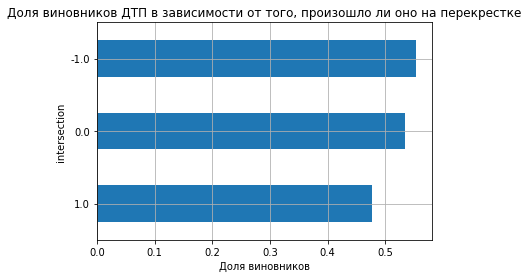

In [84]:
data_eda.groupby('intersection')['at_fault'].mean().sort_values().plot.barh(grid=True);
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от того, произошло ли оно на перекрестке');

Посмотрим, где чаще всего происходили ДТП.

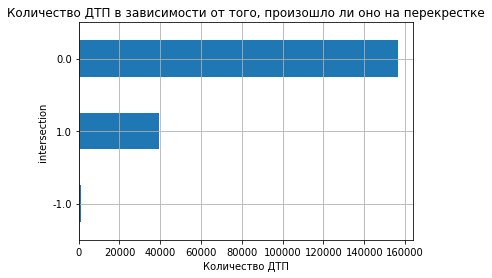

In [85]:
data_eda.groupby('intersection')['at_fault'].count().sort_values().plot.barh(grid=True);
plt.xlabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от того, произошло ли оно на перекрестке');

**Резюме:**  
Чаще всего ДТП происходили не на перекрестка. При этои доля виновников в ДТП, произошедших на перекрестке и вне него практически не отличается.    
Этот признак можно исключить из дальнейшего анализа.

#### 4.1.13 Признак `at_fault` (таргет)

In [86]:
print('Количество пропусков', data_eda['at_fault'].isna().sum())
data_eda['at_fault'].value_counts(normalize=True)

Количество пропусков 0


1    0.523514
0    0.476486
Name: at_fault, dtype: float64

**Резюме:**  
Соотношение классов сбалансировано.

### Вещественные признаки

На данном этапе исследуем вещественные признаки.

In [87]:
data_eda.select_dtypes(exclude='object').nunique()

cellphone_in_use       3
distance            2321
intersection           3
collision_time        26
vehicle_age           20
at_fault               2
dtype: int64

Из всех этих признаков нам осталось исследовать признаки `distance` и `vehicle_age`.

#### 4.1.14 Признак `distance`

In [88]:
print('Количество пропусков', data_eda['distance'].isna().sum())
data_eda['distance'].describe()

Количество пропусков 0


count    1.968370e+05
mean     6.624782e+02
std      7.915264e+03
min      0.000000e+00
25%      1.000000e+01
50%      1.000000e+02
75%      5.000000e+02
max      1.584000e+06
Name: distance, dtype: float64

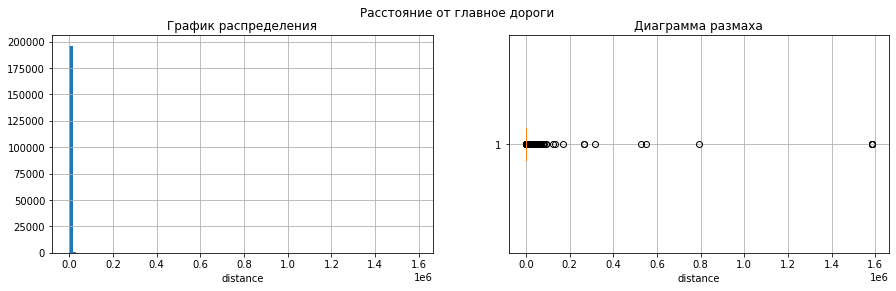

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Расстояние от главное дороги')

ax[0].hist(data_eda['distance'], bins=100)
ax[0].set_title('График распределения')
ax[0].set_xlabel('distance')
ax[0].grid()

ax[1].boxplot(data_eda['distance'].dropna(), vert=False)
ax[1].set_title('Диаграмма размаха')
ax[1].set_xlabel('distance')
ax[1].grid()

Присутсвует выброс, аномальное значение. Его можно удалить.

In [90]:
print(data_eda[data_eda['distance'] > 0.2*1e6].shape[0])
data_eda[data_eda['distance'] > 0.2*1e6]

10


,party_sobriety,party_drug_physical,cellphone_in_use,distance,intersection,location_type,weather_1,road_surface,road_condition_1,lighting,control_device,collision_time,vehicle_type,vehicle_transmission,vehicle_age,at_fault
2272,had not been drinking,unknown,0.0,528000.0,0.0,unknown,clear,dry,normal,dark with street lights,functioning,2.0,unknown,None,NaN,1
8990,had not been drinking,unknown,0.0,1584000.0,0.0,unknown,clear,dry,normal,daylight,functioning,16.0,unknown,None,NaN,1
22211,had not been drinking,unknown,-1.0,264000.0,0.0,unknown,clear,dry,normal,dark with street lights,unknown,18.0,unknown,None,NaN,0
49401,impairment unknown,unknown,-1.0,264000.0,0.0,unknown,clear,dry,normal,dark with street lights,unknown,18.0,unknown,None,NaN,1
91417,had not been drinking,unknown,0.0,1584000.0,0.0,unknown,clear,dry,normal,daylight,functioning,16.0,unknown,None,NaN,0
105801,had not been drinking,unknown,0.0,1584000.0,0.0,highway,clear,dry,normal,daylight,unknown,16.0,sedan,manual,3.0,1
132648,had not been drinking,unknown,0.0,549120.0,0.0,unknown,clear,dry,normal,daylight,unknown,15.0,unknown,None,NaN,1
143982,"had been drinking, impairment unknown",unknown,-1.0,316800.0,0.0,unknown,clear,dry,normal,daylight,functioning,18.0,unknown,None,NaN,1
155668,impairment unknown,unknown,-1.0,792000.0,0.0,unknown,clear,dry,normal,daylight,functioning,9.0,unknown,None,NaN,1
193056,had not been drinking,unknown,0.0,1584000.0,0.0,highway,clear,dry,normal,daylight,unknown,16.0,unknown,None,NaN,0


Всего лишь 10 объектов имеют расстояние до главной дороги более 200000 метров.

In [91]:
def set_thresh(series):
    Q1 = series.quantile(.25) #25%-й квантиль
    Q3 = series.quantile(.75) #75%-й квантиль
    IQR = Q3 - Q1                      #интреквантильный размах

    min_thresh = (Q1 - 1.5 * IQR if Q1 - 1.5 * IQR > series.min() else series.min()) #минимальный порог, исключающий выбросы
    max_thresh = (Q3 + 1.5 * IQR if Q3 + 1.5 * IQR < series.max() else series.max()) #максимальный порог, исключающий выбросы
    return round(min_thresh, 1), round(max_thresh, 1)

In [92]:
min_dist, max_dist = set_thresh(data_eda['distance'])

# Создадим маску для фильтрации выбросов.
distance_excl_outl = data_eda['distance'] < max_dist

print('% удаленных данных:', 1 - data_eda[distance_excl_outl].shape[0] / data_eda.shape[0])

% удаленных данных: 0.11380482328017594


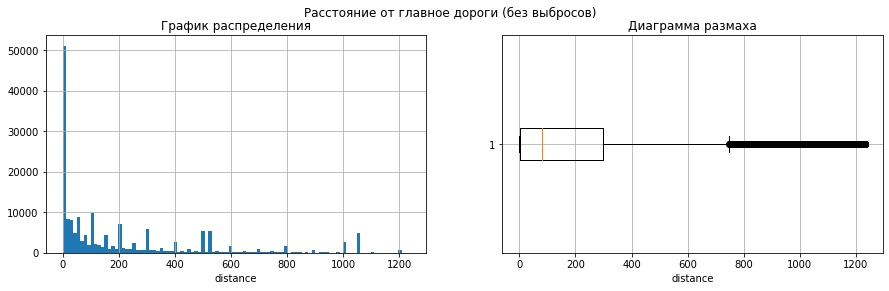

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Расстояние от главное дороги (без выбросов)')

ax[0].hist(data_eda[distance_excl_outl]['distance'], bins=100)
ax[0].set_title('График распределения')
ax[0].set_xlabel('distance')
ax[0].grid()

ax[1].boxplot(data_eda[distance_excl_outl]['distance'].dropna(), vert=False)
ax[1].set_title('Диаграмма размаха')
ax[1].set_xlabel('distance')
ax[1].grid()

Посмотрим, сколько значений 0. То есть сколько присшествий произошло на главной дороге.

In [94]:
data_eda[data_eda['distance'] == 0]['distance'].count() / data_eda.shape[0]

0.2213405000076205

22 процента происшествий произошло на главной дороге.  
Можно попробовать сделать бинарный признак "присшествие произошло на главной дороге"

Посмотрим, зависит ли как-то факт вины водителя от расстояния до главной дороги.

In [95]:
data_eda[distance_excl_outl].groupby('at_fault')['distance'].median()

at_fault
0    75.0
1    85.0
Name: distance, dtype: float64

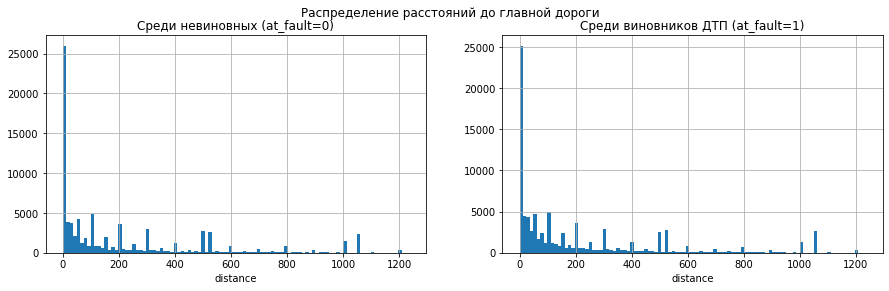

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Распределение расстояний до главной дороги')

ax[0].hist(data_eda[(distance_excl_outl) & (data_eda['at_fault'] == 0)]['distance'], bins=100)
ax[0].set_title('Среди невиновных (at_fault=0)')
ax[0].set_xlabel('distance')
ax[0].grid()

ax[1].hist(data_eda[(distance_excl_outl) & (data_eda['at_fault'] == 1)]['distance'], bins=100)
ax[1].set_title('Среди виновников ДТП (at_fault=1)')
ax[1].set_xlabel('distance')
ax[1].grid()

Проведем небольшой тест Манна-Уитни и сравним распределения.  
Сформулируем гипотезы:  
- Нулевая гипотеза (H0): расстояние до главной дороги у виновных в ДТП такое же, как и у невиновных.
- Альтернативная гипотеза (H1): расстояние до главной дороги у виновных в ДТП больше, чем у невиновных.

In [97]:
_, pvalue = st.mannwhitneyu(data_eda[(distance_excl_outl) & (data_eda['at_fault'] == 0)]['distance'].values, 
                            (data_eda[(distance_excl_outl) & (data_eda['at_fault'] == 1)]['distance']).values, 
                            alternative='less') 

alpha = 0.05

print('pvalue:', pvalue)
if pvalue < (alpha):
    print('Отвергаем гипотезу H0')
else:
    print('Гипотеза HO не может быть отвергнута')

pvalue: 3.061376199613164e-16
Отвергаем гипотезу H0


Похоже, что разница между расстояниями у виновных в ДТП и невиновных статистически значима с уровнем значимости в 5%

**Резюме**  
С одной стороны признак можно включить в анализ. Но с другой стороны, для его включения придется удалить 11% данных, чтобы исключить выбросы.  
Учитывая большую сложность рассчета данного признака на старте маршрута (расстояние до главной дороги на построенном водителем маршруте скорее всего будет непостоянным), возможно, данный признак лучше всего будет отбросить.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Отлично, заодно и ранее пройденный материал вспомнили. </div>

#### 4.1.15 Признак `vehicle_age`

In [98]:
print('Количество пропусков', data_eda['vehicle_age'].isna().sum())
data_eda['vehicle_age'].describe()

Количество пропусков 142283


count    54554.000000
mean         4.856472
std          3.234503
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

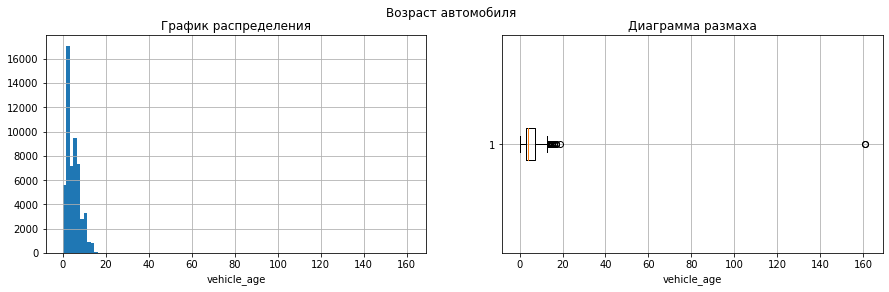

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Возраст автомобиля')

ax[0].hist(data_eda['vehicle_age'], bins=100)
ax[0].set_title('График распределения')
ax[0].set_xlabel('vehicle_age')
ax[0].grid()

ax[1].boxplot(data_eda['vehicle_age'].dropna(), vert=False)
ax[1].set_xlabel('vehicle_age')
ax[1].set_title('Диаграмма размаха')
ax[1].grid()

Присутствует выброс, аномальное значение. Его можно удалить.

In [100]:
print(data_eda[data_eda['vehicle_age'] > 20].shape[0])
data_eda[data_eda['vehicle_age'] > 20]

2


,party_sobriety,party_drug_physical,cellphone_in_use,distance,intersection,location_type,weather_1,road_surface,road_condition_1,lighting,control_device,collision_time,vehicle_type,vehicle_transmission,vehicle_age,at_fault
104392,had not been drinking,unknown,0.0,0.0,1.0,ramp,clear,dry,normal,dusk or dawn,functioning,6.0,sedan,manual,161.0,0
184208,had not been drinking,unknown,0.0,449.0,0.0,unknown,clear,dry,normal,daylight,unknown,12.0,sedan,manual,161.0,1


Всего лишь 2 объекта имеют обладают возрастом 161 год. Похоже на ошибку. Заменим эти два значения на пропуски.

In [101]:
# Заменим значение 'other' на 'unknown', так как они эквивалентны
data_eda['vehicle_age'] = data_eda['vehicle_age'].mask(data_eda['vehicle_age'] == 161, np.nan)

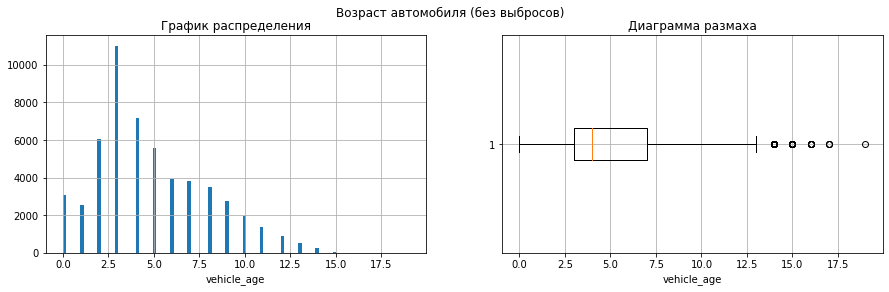

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Возраст автомобиля (без выбросов)')

ax[0].hist(data_eda['vehicle_age'], bins=100)
ax[0].set_title('График распределения')
ax[0].set_xlabel('vehicle_age')
ax[0].grid()

ax[1].boxplot(data_eda['vehicle_age'].dropna(), vert=False)
ax[1].set_xlabel('vehicle_age')
ax[1].set_title('Диаграмма размаха')
ax[1].grid()

Посмотрим, зависит ли как-то факт вины водителя от возраста автомобиля.

In [103]:
agg_ages = data_eda.groupby('vehicle_age')['at_fault'].agg(['mean', 'count']).sort_index()
agg_ages

,mean,count
vehicle_age,,
0.0,0.439909,3087
1.0,0.421611,2545
2.0,0.564319,6048
3.0,0.618144,11012
4.0,0.524661,7157
5.0,0.463792,5565
6.0,0.443655,3940
7.0,0.454143,3838
8.0,0.416643,3509


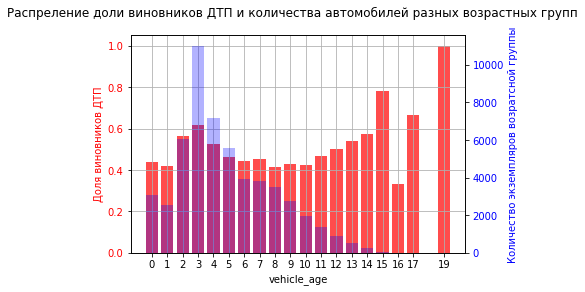

In [104]:
fig, ax1 = plt.subplots() 
fig.suptitle('Распреление доли виновников ДТП и количества автомобилей разных возрастных групп')
plt.grid()

ax1.bar(agg_ages.index, agg_ages['mean'], color = 'red', alpha=0.7)
ax1.set_xlabel('vehicle_age') 
ax1.set_ylabel('Доля виновников ДТП', color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red')
ax1.set_xticks(agg_ages.index)

ax2 = ax1.twinx() 
ax2.bar(agg_ages.index, agg_ages['count'], color = 'blue', alpha=0.3)
ax2.set_ylabel('Количество экземпляров возратсной группы', color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

plt.show()

Сравним распределения виновных и невиновных в ДТП автомобилей.

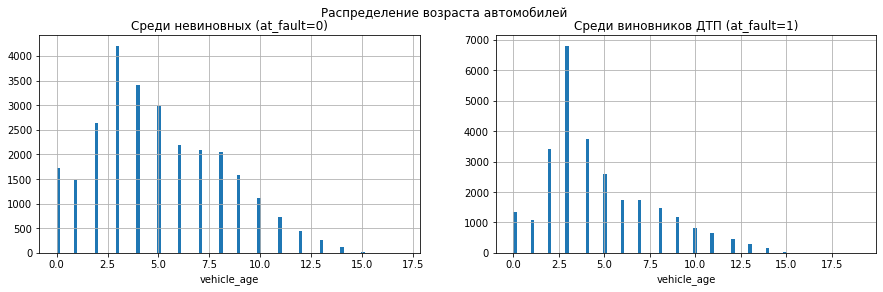

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Распределение возраста автомобилей')

ax[0].hist(data_eda[data_eda['at_fault'] == 0]['vehicle_age'], bins=100)
ax[0].set_title('Среди невиновных (at_fault=0)')
ax[0].set_xlabel('vehicle_age')
ax[0].grid()

ax[1].hist(data_eda[data_eda['at_fault'] == 1]['vehicle_age'], bins=100)
ax[1].set_title('Среди виновников ДТП (at_fault=1)')
ax[1].set_xlabel('vehicle_age')
ax[1].grid()

Проведем небольшой тест Манна-Уитни.  
Сформулируем гипотезы:  
- Нулевая гипотеза (H0): возраст автомобиля у виновников ДТП такой же как и у «невиновников».
- Альтернативная гипотеза (H1): возраст автомобиля у виновников ДТП ниже чем и у «невиновников».

In [106]:
_, pvalue = st.mannwhitneyu(data_eda[data_eda['at_fault'] == 1]['vehicle_age'].dropna().values, 
                            data_eda[data_eda['at_fault'] == 0]['vehicle_age'].dropna().values,
                            alternative='less')

alpha = 0.05

print('pvalue:', pvalue)
if pvalue < (alpha):
    print('Отвергаем гипотезу H0')
else:
    print('Гипотеза HO не может быть отвергнута')

pvalue: 1.8863427053227397e-57
Отвергаем гипотезу H0


Похоже, что разница в возрасте автомобиля виновников ДТП и невиновных все же статистически значима (при уровне значимости в 5%)

**Резюме**  
Похоже, что наибольшая доля виновников ДТП приходится на автомобили с вохрастом 2-4 года. Сравнение рапсредлений виновных и невиновных автомобилей показало, что возраст у автомобилей виновных в ДТП ниже, чем у невиновных, и эта разница статистически значима (при уровне значимости 5%)  
Этот признак будет использован в ходе моделирования.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Отлично!🔥 Интересное исследование получилось. Я бы рекомендовал вообще  ограничить возраст  машины для каршеринга, поставить например не старше 10 лет, а ещё лучше пробегом. </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Интересная идея, спасибо! Кстати на счет пробега согласен, это как будто бы более информативный признак был бы</div>

### 4.2 Предоработка данных

Итак, для дальнейшей работы было принято взять следующие признаки:
- `party_sobriety`
- `party_drug_physical`
- `weather_1`
- `road_condition_1`
- `lighting`
- `ehicle_type`
- `collision_time`
- `vehicle_age`

In [107]:
model_features = ['party_sobriety', 'party_drug_physical', 'weather_1', 'road_condition_1', 
                  'lighting', 'vehicle_type', 'collision_time', 'vehicle_age']

In [108]:
data_eda[model_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   party_sobriety       196837 non-null  object 
 1   party_drug_physical  196837 non-null  object 
 2   weather_1            196837 non-null  object 
 3   road_condition_1     196837 non-null  object 
 4   lighting             196837 non-null  object 
 5   vehicle_type         196837 non-null  object 
 6   collision_time       196837 non-null  float64
 7   vehicle_age          54552 non-null   float64
dtypes: float64(2), object(6)
memory usage: 12.0+ MB


In [109]:
data_eda[model_features].head()

,party_sobriety,party_drug_physical,weather_1,road_condition_1,lighting,vehicle_type,collision_time,vehicle_age
0,had not been drinking,unknown,cloudy,normal,daylight,sedan,17.0,1.0
1,had not been drinking,unknown,clear,normal,dark with no street lights,unknown,18.0,NaN
2,had not been drinking,unknown,clear,normal,daylight,unknown,8.0,NaN
3,impairment unknown,unknown,clear,normal,daylight,unknown,9.0,NaN
4,had not been drinking,unknown,clear,normal,daylight,unknown,13.0,NaN


Все пропуски в категориальных столбцах на этапе исследовательского анализа были заполнены на "unknown". Также к категории "unknown" были приведены значения по типу "Other", "Not Applicable" так как это фактически точно такие же неизвестные для нас величины.  
Пропуски столбце `collision_time` были заполнены -1 - так как мы будем использовать в основном деревянные модели для дальнейшего анализа - это значение вполне подходит.  
Аналогично заполним пропуски в столбце `vehicle_age`

In [110]:
data_eda['vehicle_age'] = data_eda['vehicle_age'].fillna(-1)

In [111]:
data_eda[model_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   party_sobriety       196837 non-null  object 
 1   party_drug_physical  196837 non-null  object 
 2   weather_1            196837 non-null  object 
 3   road_condition_1     196837 non-null  object 
 4   lighting             196837 non-null  object 
 5   vehicle_type         196837 non-null  object 
 6   collision_time       196837 non-null  float64
 7   vehicle_age          196837 non-null  float64
dtypes: float64(2), object(6)
memory usage: 12.0+ MB


In [112]:
# Сохраним таргет в переменную "target"
target = data_eda['at_fault']

In [113]:
cat_columns = data_eda[model_features].select_dtypes('object').columns

#### 4.2.1 Подготовка данных для случайного леса

Используем Ordinal кодирование категориальных признаков.

In [114]:
ct = ColumnTransformer([('ord_enc', OrdinalEncoder(), cat_columns)], remainder='passthrough')

features_rf = ct.fit_transform(data_eda[model_features])

In [115]:
rf_train_X, rf_test_X, rf_train_y, rf_test_y = train_test_split(features_rf, target, test_size=0.2, 
                                                                random_state=0, stratify=target)

In [116]:
rf_train_X.shape, rf_test_X.shape

((157469, 8), (39368, 8))

In [117]:
rf_train_y.mean(), rf_test_y.mean()

(0.5235125643777505, 0.5235216419426946)

#### 4.2.2 Подготовка данных для градиентного бустинга

Преобразуем категоральные признаки к типу "category":

In [122]:
features_gb = data_eda[model_features]
features_gb[cat_columns] = features_gb[cat_columns].astype('category')

features_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   party_sobriety       196837 non-null  category
 1   party_drug_physical  196837 non-null  category
 2   weather_1            196837 non-null  category
 3   road_condition_1     196837 non-null  category
 4   lighting             196837 non-null  category
 5   vehicle_type         196837 non-null  category
 6   collision_time       196837 non-null  float64 
 7   vehicle_age          196837 non-null  float64 
dtypes: category(6), float64(2)
memory usage: 4.1 MB


In [123]:
gb_train_X, gb_test_X, gb_train_y, gb_test_y = train_test_split(features_gb, target, test_size=0.2, 
                                                                random_state=0, stratify=target)

In [124]:
gb_train_X.shape, gb_test_X.shape

((157469, 8), (39368, 8))

In [125]:
gb_train_y.mean(), gb_test_y.mean()

(0.5235125643777505, 0.5235216419426946)

#### 4.2.3 Преобразуем данные для линейной модели

In [126]:
features_lm = data_eda[model_features]

In [127]:
features_lm.head()

,party_sobriety,party_drug_physical,weather_1,road_condition_1,lighting,vehicle_type,collision_time,vehicle_age
0,had not been drinking,unknown,clear,construction,daylight,unknown,9.0,-1.0
1,had not been drinking,unknown,clear,normal,daylight,unknown,16.0,-1.0
2,had not been drinking,unknown,clear,obstruction,daylight,unknown,8.0,-1.0
3,had not been drinking,unknown,cloudy,normal,dark with street lights,coupe,5.0,8.0
4,had not been drinking,unknown,cloudy,normal,daylight,unknown,8.0,-1.0


- Категориальные признаки преобразуем методом OneHotEncoding.  
- Признак `collision_time`- заменим "-1" на медиану и применим синусно-косинусное преобразование.
- Признак `vehicle_age` - "-1" заменим на медиану.

In [128]:
# Сначала преобразуем "-1" обратно к Nan
features_lm['collision_time'] = features_lm['collision_time'].mask(features_lm['collision_time'] == -1, np.nan)
features_lm['vehicle_age'] = features_lm['vehicle_age'].mask(features_lm['vehicle_age'] == -1, np.nan)

# Сделаем OneHotEncoding категориальных столбцов
ct = ColumnTransformer([('ohe', OneHotEncoder(drop='first', sparse=False), cat_columns)], remainder='passthrough')
features_lm = ct.fit_transform(features_lm)

In [129]:
# Разделим на тренировочную и тестовую выборки
lm_train_X, lm_test_X, lm_train_y, lm_test_y = train_test_split(features_lm, target, test_size=0.2, 
                                                                random_state=0, stratify=target)

In [130]:
# Заполним пропуски в столбцах "collision_time", "vehicle_age" 
imp = SimpleImputer(strategy='median')
lm_train_X[:, -2:] = imp.fit_transform(lm_train_X[:, -2:])
lm_test_X[:, -2:] = imp.transform(lm_test_X[:, -2:])

# Масштабируем признак "vehicle_age"
scaler = StandardScaler()
lm_train_X[:, -1] = scaler.fit_transform(lm_train_X[:, -1].reshape(-1, 1)).flatten()
lm_test_X[:, -1] = scaler.transform(lm_test_X[:, -1].reshape(-1, 1)).flatten()

In [131]:
# Делаем косинусно-синусное преобразование признака "collision_time"
cos_x_train = np.cos(2 * math.pi * lm_train_X[:, -2] / 24)
sin_x_train = np.sin(2 * math.pi * lm_train_X[:, -2] / 24)

cos_x_test = np.cos(2 * math.pi * lm_test_X[:, -2] / 24)
sin_x_test = np.sin(2 * math.pi * lm_test_X[:, -2] / 24)

# Конкатенируем столбцы с синусом и косинусом
sin_cos_train = np.concatenate([sin_x_train.reshape(-1, 1), cos_x_train.reshape(-1, 1)], axis=1)
sin_cos_test = np.concatenate([sin_x_test.reshape(-1, 1), cos_x_test.reshape(-1, 1)], axis=1)

# Удаляем оригинальный столбец с временем и добавляем столбцы с "синусом" и "косинусом" признака.
lm_train_X = np.delete(lm_train_X, -2, 1)
lm_train_X = np.append(lm_train_X, sin_cos_train, axis=1)

lm_test_X = np.delete(lm_test_X, -2, 1)
lm_test_X = np.append(lm_test_X, sin_cos_test, axis=1)

In [132]:
lm_train_X.shape, lm_test_X.shape

((157469, 31), (39368, 31))

In [133]:
lm_train_y.mean(), lm_test_y.mean()

(0.5235125643777505, 0.5235216419426946)

Итого, последние два столбца - это синус и косинус времени. Третий признак с конца - возраст авто.

### Резюме

На данном этапе:  
- Были предварительно отобраны признаки для моделирования. Каждый признак был детально изучен
- На основании проведенного анализа финально были выбраны признаки для моделирования
- Признаки былм предобработаны для трех типов моделей: для линейных, для случайного леса и для градиентного бустинга.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Данные готовы!Хорошо! </div>

## 5. Анализ важности факторов ДТП

На данном этапе построим три модели и сравним их обобщающие способности:  
- Логистическая регрессия
- Случайный лес
- Градиентный бустинг
 
В качестве метрики будет взято гармоническое среднее precision и recall — f1-score. В рамках задачи нам важно не только охватить как можно большее количество случаев, в которых у водителя есть риск стать виновником ДТП (recall), но и постараться построить такой классификатор, который будет обладать максимальной точностью (precision). При этом, построив график preciion-recall curve мы можем баланисровать порог классификатора, если будет необходимость уделить одной из метрик большее внимание.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Хорошо, что берешь "полноту" и "точность", эти показатели для бизнеса проще интерпритируемы, я можно добавить Accuracy, как обобщенную вспомогательную метрику. </div>

### 5.0 Dummy classifier

In [175]:
dum_clf = DummyClassifier(strategy='prior', random_state=0)
cv_f1_dummy = cross_val_score(dum_clf, lm_train_X, lm_train_y, scoring='f1', cv=5, error_score='raise')
cv_pr_dummy = cross_val_score(dum_clf, lm_train_X, lm_train_y, scoring='precision', cv=5, error_score='raise')
cv_rc_dummy = cross_val_score(dum_clf, lm_train_X, lm_train_y, scoring='recall', cv=5, error_score='raise')

print('Dummy Clf F1:', cv_f1_dummy.mean())
print('Dummy Clf precision:', cv_pr_dummy.mean())
print('Dummy Clf recall:', cv_rc_dummy.mean())

Dummy Clf F1: 0.6872441705226734
Dummy Clf precision: 0.5235125643815436
Dummy Clf recall: 1.0


### 5.1 Логистическая регрессия

In [183]:
scoring = {"F1": "f1", "Precision": "precision", "Recall": "recall"}

In [188]:
lr = LogisticRegression(random_state=0, class_weight='balanced', penalty='elasticnet', solver='saga')
params_lr = {'l1_ratio': [0.2, 0.8], 
          'C': [0.8, 0.4]}

gcv_lr = GridSearchCV(lr, params_lr, refit='F1', scoring=scoring, cv=5, error_score='raise', verbose=2)

In [189]:
gcv_lr.fit(lm_train_X, lm_train_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................................C=0.8, l1_ratio=0.2; total time=   3.2s
[CV] END ................................C=0.8, l1_ratio=0.2; total time=   3.3s
[CV] END ................................C=0.8, l1_ratio=0.2; total time=   3.3s
[CV] END ................................C=0.8, l1_ratio=0.2; total time=   3.0s
[CV] END ................................C=0.8, l1_ratio=0.2; total time=   3.6s
[CV] END ................................C=0.8, l1_ratio=0.8; total time=   3.2s
[CV] END ................................C=0.8, l1_ratio=0.8; total time=   3.2s
[CV] END ................................C=0.8, l1_ratio=0.8; total time=   3.6s
[CV] END ................................C=0.8, l1_ratio=0.8; total time=   3.0s
[CV] END ................................C=0.8, l1_ratio=0.8; total time=   3.7s
[CV] END ................................C=0.4, l1_ratio=0.2; total time=   2.7s
[CV] END ................................C=0.4, l

GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(class_weight='balanced',
                                          penalty='elasticnet', random_state=0,
                                          solver='saga'),
             param_grid={'C': [0.8, 0.4], 'l1_ratio': [0.2, 0.8]}, refit='F1',
             scoring={'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'},
             verbose=2)

In [190]:
print('Logistic Regression best F1:', gcv_lr.best_score_)
print('Logistic Regression best params:', gcv_lr.best_params_)

Logistic Regression best F1: 0.49933345186913114
Logistic Regression best params: {'C': 0.4, 'l1_ratio': 0.2}


In [218]:
print('Logistic Regression best Pecision', pd.DataFrame(gcv_lr.cv_results_)[['split0_test_Precision', 'split1_test_Precision', 'split2_test_Precision', 'split3_test_Precision', 'split4_test_Precision']].loc[gcv_gb.best_index_].mean())

Logistic Regression best Pecision 0.7989266196202301


In [219]:
print('Logistic Regression best Recall', pd.DataFrame(gcv_lr.cv_results_)[['split0_test_Recall', 'split1_test_Recall', 'split2_test_Recall', 'split3_test_Recall', 'split4_test_Recall']].loc[gcv_gb.best_index_].mean())

Logistic Regression best Recall 0.3631621551357109


In [191]:
# Посмотри на коэффциенты на предмет переобучения.
gcv_lr.best_estimator_.coef_

array([[-7.22982277e-01,  1.43144632e+00, -1.81639119e+00,
        -2.63258854e-02, -1.59179539e+00,  3.25155373e+00,
         2.24852996e+00, -9.35107168e-04,  1.54150345e-01,
         2.21109350e-01,  3.09715831e-01,  7.31547122e-01,
        -4.40776574e-01, -5.69949496e-01,  7.92225131e-01,
         1.36678609e-01,  4.46073716e-01,  1.50475757e-01,
         1.07098983e-01,  2.07955269e-01, -2.07919471e-02,
        -2.09823226e-01, -2.14269899e-01, -1.58428217e-01,
        -1.53871458e-01, -3.84928908e-01, -5.46561251e-01,
        -3.95851815e-01, -9.38624085e-02,  6.09951395e-02,
        -3.01712076e-02]])

С коэффициентами все ок, они примерно одного масштаба.

**Резюме:**   
Логистическая регрессия показала результат хуже константного алгоритма. Вероятно, эта модель не подходит для решения данной задачи.

### 5.2 Случайный лес

In [192]:
rf = RandomForestClassifier(max_features='sqrt', random_state=0, class_weight='balanced')
params_rf = {'n_estimators': [200, 500, 700], 
             'criterion': ["gini", "entropy"]}

gcv_rf = GridSearchCV(rf, params_rf, refit='F1', scoring=scoring, cv=5, error_score='raise', verbose=2)

In [193]:
gcv_rf.fit(rf_train_X, rf_train_y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................criterion=gini, n_estimators=200; total time=  11.7s
[CV] END ...................criterion=gini, n_estimators=200; total time=  12.0s
[CV] END ...................criterion=gini, n_estimators=200; total time=  11.9s
[CV] END ...................criterion=gini, n_estimators=200; total time=  11.5s
[CV] END ...................criterion=gini, n_estimators=200; total time=  12.3s
[CV] END ...................criterion=gini, n_estimators=500; total time=  30.0s
[CV] END ...................criterion=gini, n_estimators=500; total time=  29.0s
[CV] END ...................criterion=gini, n_estimators=500; total time=  30.4s
[CV] END ...................criterion=gini, n_estimators=500; total time=  29.5s
[CV] END ...................criterion=gini, n_estimators=500; total time=  30.1s
[CV] END ...................criterion=gini, n_estimators=700; total time=  43.0s
[CV] END ...................criterion=gini, n_est

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [200, 500, 700]},
             refit='F1',
             scoring={'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'},
             verbose=2)

In [194]:
print('RandomForest best F1:', gcv_rf.best_score_)
print('RandomForest best params:', gcv_rf.best_params_)

RandomForest best F1: 0.5156613295174012
RandomForest best params: {'criterion': 'gini', 'n_estimators': 200}


In [216]:
print('RandomForest best Pecision', pd.DataFrame(gcv_rf.cv_results_)[['split0_test_Precision', 'split1_test_Precision', 'split2_test_Precision', 'split3_test_Precision', 'split4_test_Precision']].loc[gcv_gb.best_index_].mean())

RandomForest best Pecision 0.7520043686024831


In [217]:
print('RandomForest best Recall', pd.DataFrame(gcv_rf.cv_results_)[['split0_test_Recall', 'split1_test_Recall', 'split2_test_Recall', 'split3_test_Recall', 'split4_test_Recall']].loc[gcv_gb.best_index_].mean())

RandomForest best Recall 0.3916203000220102


**Резюме:**  
Случайный лес показал незначительно лучший результат, нежели логистическая регрессия, однако он все еще ниже метрики, которая была получена константным классификатором.

### 5.3 Градиентный бустинг

In [195]:
gb = CatBoostClassifier(n_estimators=1000, random_state=0, auto_class_weights='Balanced')
params_gb = {'max_depth': [3, 4, 5]}

gcv_gb = GridSearchCV(gb, params_gb, refit='F1', scoring=scoring, cv=5, error_score='raise', verbose=2)

In [196]:
gcv_gb.fit(gb_train_X, gb_train_y, **{'cat_features': list(cat_columns)})

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.081237
0:	learn: 0.6816668	total: 132ms	remaining: 2m 11s
1:	learn: 0.6738362	total: 258ms	remaining: 2m 8s
2:	learn: 0.6657421	total: 371ms	remaining: 2m 3s
3:	learn: 0.6598388	total: 460ms	remaining: 1m 54s
4:	learn: 0.6547599	total: 547ms	remaining: 1m 48s
5:	learn: 0.6501968	total: 631ms	remaining: 1m 44s
6:	learn: 0.6467196	total: 724ms	remaining: 1m 42s
7:	learn: 0.6439101	total: 816ms	remaining: 1m 41s
8:	learn: 0.6414789	total: 902ms	remaining: 1m 39s
9:	learn: 0.6395312	total: 996ms	remaining: 1m 38s
10:	learn: 0.6376868	total: 1.08s	remaining: 1m 37s
11:	learn: 0.6362310	total: 1.18s	remaining: 1m 37s
12:	learn: 0.6349237	total: 1.29s	remaining: 1m 38s
13:	learn: 0.6341143	total: 1.38s	remaining: 1m 37s
14:	learn: 0.6331187	total: 1.47s	remaining: 1m 36s
15:	learn: 0.6322369	total: 1.56s	remaining: 1m 36s
16:	learn: 0.6314837	total: 1.66s	remaining: 1m 35s
17:	learn: 0.6308697	total: 1.75s	rema

GridSearchCV(cv=5, error_score='raise',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fdf17596cd0>,
             param_grid={'max_depth': [3, 4, 5]}, refit='F1',
             scoring={'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'},
             verbose=2)


<div class="alert alert-warning">
<b>Комментарий ревьюера :</b> В начале главы верно подметил, что данные сбалансированы, плюс мне кажется можно больше параметров взять для поиска по сетке. </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> В целом можно, просто из-за времени ограничился минимумом :(</div>

In [197]:
print('GradientBoosting best F1:', gcv_gb.best_score_)
print('GradientBoosting best params:', gcv_gb.best_params_)

GradientBoosting best F1: 0.5093361857316379
GradientBoosting best params: {'max_depth': 5}


In [214]:
print('GradientBoosting best Pecision', pd.DataFrame(gcv_gb.cv_results_)[['split0_test_Precision', 'split1_test_Precision', 'split2_test_Precision', 'split3_test_Precision', 'split4_test_Precision']].loc[gcv_gb.best_index_].mean())

GradientBoosting best Pecision 0.7954631943501161


In [215]:
print('GradientBoosting best Recall', pd.DataFrame(gcv_gb.cv_results_)[['split0_test_Recall', 'split1_test_Recall', 'split2_test_Recall', 'split3_test_Recall', 'split4_test_Recall']].loc[gcv_gb.best_index_].mean())

GradientBoosting best Recall 0.3746012303755297


**Резюме:**  
Результаты проверки моделей выглядят следующим образом:   

|        |  LogisticRegresssion   |  RandomForest   | GradiemtBoosting
|--------|-----------|---------|     |
| F1 |    49,9       |   51,6  |  51 | 
| Precision | 79,8   |   75,2   |79,5 |
| Recall |   36,3|   39,2      |37,5 |  

Для дальнейшего анализа возьмем модель Случайного леса, так как показатель полноты для бизнеса может быть чуть более важен, нежели показатель точности. Полнота для бизнеса может являться более важным фактором, так как недооценив риск того, что водитель может стать виновником аварии, бизнес не сможет предпринять каких-либо мер для ее предупреждения. Соответсвенно, для нас может быть важнее охватывать как можно большее количество ситуация риска и лишний раз перестраховаться и посоветовать водителю иной маршрут, нежели недооценить ситуацию и допустить аварию. Ведь аварии для нас - это потеря денег, возможно - в некоторой степени репутации. А в худшем случаем - и клиента.  
Однако это лишь мое предположение, и что важно на самом деле для заказчика лучше всего спросить у него самого.


<div class="alert alert-warning">
<b>Комментарий ревьюера :</b> Что важней полнота и точность это зависит от конкретной задачи, если считаешь, что важней полнота, то нужно пояснить почему именно для этой задачи это важно. Также прежде чем выбирать модель можно также посмотреть на матрицу ошибок, возможно какя-то модель выдает много ложно-положительных прогнозов, также думаю если чуть "подкрутить параметры" catboost, метркики будут лучше. </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Дописал обоснование :)</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> А по поводу высокого количества ложноположительных, я для этого вывел метрику точности. Ведь если высока точность (precision), то вроде как это означает, что ложноположительных мало совсем:) Если я ничего не путаю ) </div>

## 6. Проверка лучшей модели в работе

In [118]:
# Возьмем наилучшую итерацию и learning rate и обучим модель
rf_best = RandomForestClassifier(criterion='gini', max_depth=200, max_features='sqrt', random_state=0, class_weight='balanced')

In [119]:
rf_best.fit(rf_train_X, rf_train_y)

RandomForestClassifier(class_weight='balanced', max_depth=200,
                       max_features='sqrt', random_state=0)

In [120]:
# Сделаем предсказания на тесте
test_pred = rf_best.predict(rf_test_X)
test_pred_proba = rf_best.predict_proba(rf_test_X)

In [121]:
print('F1 Score', f1_score(rf_test_y, test_pred))
print('Precision', precision_score(rf_test_y, test_pred))
print('Recall', recall_score(rf_test_y, test_pred))
print('ROC AUC', roc_auc_score(rf_test_y, test_pred_proba[:, 1]))

F1 Score 0.5171216513235435
Precision 0.7527589724566447
Recall 0.3938379427462397
ROC AUC 0.6513740836256621


In [122]:
# Зададим функцию, которая построит график Precision-Recall
def precision_recall_plot(title=None, model=None, X=None, y=None, ax=None):
    probabilities_valid = model.predict_proba(X)
    precision, recall, thresholds = precision_recall_curve(y, probabilities_valid[:, 1])

    ax.step(recall, precision, where='post')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
# Зададим функцию, которая построит график ROC_AUC
def roc_curve_plot(title='ROC-кривая', model=None, X=None, y=None, ax=None):
    probabilities_valid = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probabilities_valid[:, 1]) 
    
    ax.step(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)

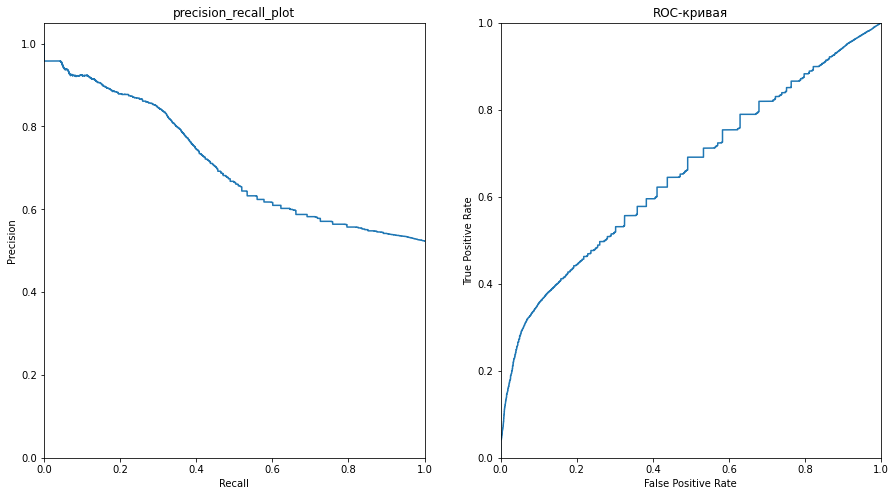

In [123]:
# Построим roc_auc curve и pr_curve
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

precision_recall_plot(title='precision_recall_plot', model=rf_best, X=rf_test_X, y=rf_test_y, ax=ax[0])
roc_curve_plot(model=rf_best, X=rf_test_X, y=rf_test_y, ax=ax[1])

In [124]:
# Построим отчет по классификации
print(classification_report(rf_test_y, test_pred))

              precision    recall  f1-score   support

           0       0.56      0.86      0.68     18758
           1       0.75      0.39      0.52     20610

    accuracy                           0.61     39368
   macro avg       0.66      0.63      0.60     39368
weighted avg       0.66      0.61      0.59     39368



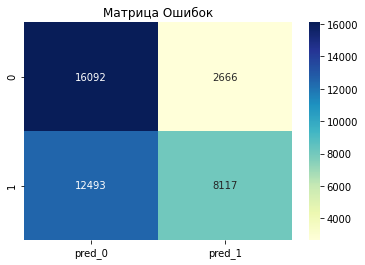

In [131]:
# Выведем матрицу ошибок
sns.heatmap(pd.DataFrame(confusion_matrix(rf_test_y, test_pred), index=[0, 1], columns=['pred_0', 'pred_1']), annot=True, fmt="d", cmap="YlGnBu")
plt.title('Матрица Ошибок');

 <div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Оформи её пожалуйста), чтоб наглядно было. </div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Убрал датафрейм, сделал хитмап</div>

**Резюме:**  
Среди тех случаем, которые модель определила как "виновник ДТП" - модель права в 75% случаев. Это хороший результат, и это означает, что она выдает очень мало False Positive ответов. Иными словами, если риска нет - модель не сообщит, что риск есть.  
Однако большой недостаток состоит в том, что среди всех объектов класса "виновен" модель определяет недостаточное количество экземпяров, большую часть объектов класса "виновен" модель просто не распознала и ошибочно определила их к классу 0. Иными словами, модель допускает большое количество False Negative ошибок. И что важно, для бизнеса эта ошибка может стоит гораздо дороже. В данном случае, полнота для нас возможно даже чуть более важна, нежели точность. Хотя, конечно, в идеале хотелось бы соблюсти баланс.

### Оценим важность признаков

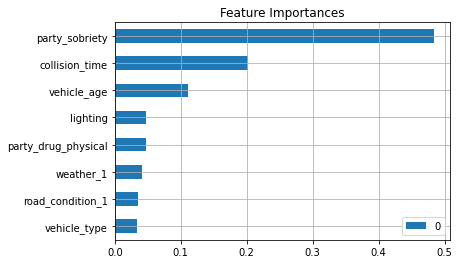

In [133]:
pd.DataFrame(rf_best.feature_importances_, index=data_eda[model_features].columns).sort_values(0, ascending=True).plot.barh(grid=True);
plt.title('Feature Importances');

Одними из наиболее важных признаков, является трезвость и физическое состояние водителя. 

Посмотрим как факт вины водителя зависит от степени трезвости.

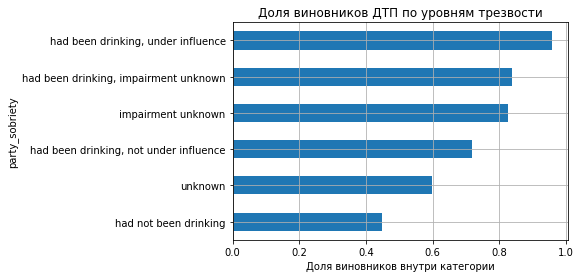

In [135]:
data_eda.groupby('party_sobriety')['at_fault'].mean().sort_values().plot.barh(grid=True)
plt.xlabel('Доля виновников внутри категории')
plt.title('Доля виновников ДТП по уровням трезвости');

Наибольшее количество виновников ДТП были в состоянии алкогольного опьянения.  

Посмотрим также на то, как факт вины водителя зависит его времени аварии.

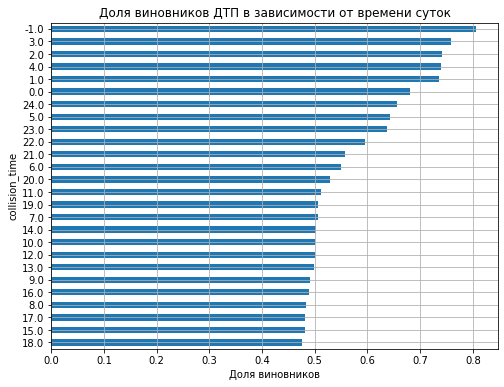

In [136]:
data_eda.groupby('collision_time')['at_fault'].mean().sort_values().plot.barh(grid=True, figsize=(8, 6));
plt.xlabel('Доля виновников')
plt.title('Доля виновников ДТП в зависимости от времени суток');

Большинство аварий происходят в промежутке с 23 вечера до 5 утра.

### Резюме

Чтобы повлиять на фактор риска "уровень трезвости", можно предпринять следующие меры:  
- Оборудовать автомобиль прибором для измерения уровня алкоголя в крови. Проверка должна быть обязательна. Для того, чтобы убедиться, что в аппарат дышит водитель авто, можно соорудить камеру. 

Чтобы повлиять на фактор риска "время", можно предпринять следующие меры: 
- Поставить камеру, которая будет отслеживать уровень усталости водителя, и в случае признаков сна давать какой-либо звуковой сигнал, либо голосовое напоминание. Ведь фактор времени скорее всего влияет на общее состояние водителя, его усталость.
- Дополнительным решением может служить рекомендация водителю маршрутов с хорошим освещением. Ведь фактор освещения также заложен в признак "время"

## 6. Выводы

Задачу можно подразделить на две части: 
- Предсказание вероятности того, что ДТП произойдет при тех или иных условиях (состояние водителя, состяние дороги, состояние погоды, время и тд). Но для этого нам тербуется информация об автомобилях, которые в ДТП при этих же условиях не попали.
- Предсказание того, что в случившемся ДТП водитель будет виновником при тех или иных усовиях (состояние водителя, состяние дороги, состояние погоды, время и тд). Эта по сути и есть та задача, которую мы решали по требованию заказчика. Предсказывали целевое значение `at_fault`  
В рамках поставленной задачи, условий и доступных признаков, лучший результат, который удалось получить на тесте - f1=51% . Это не удовлетворительный результат для того, чтобы запускать модель в продакшн. Для построения более точно модели все же хотелось бы получить больше данных, которые касаются вероятности аварии в целом на тех или иных участках маршрута. А также, возможно полезным было бы добавить к признакам возраст водителя и его стаж, если речь идет о предсказании вины водителя. Таким образом, в идеале, финальное предсказание хотелось бы строить на основании двух моделей: модели, которая предсказывает вероятность аварии в тех или иных дорожных и погодных условиях в целом и модели, которая предсказывает вину водителя.  

Из тех данных, которые имелись, на основании исследовательского анализа были взяты следубщие признаки для моделирования:  
- `party_sobriety`
- `party_drug_physical`
- `weather_1`
- `road_condition_1`
- `lighting`
- `vehicle_type`
- `collision_time`
- `vehicle_age`  

На основании этих признков была построена модель случайного леса. С помощью модели удалось выяснить, что наиболее значимыми признаками, которые определяли вину автомобилиста являлись уровень его трезвости и время суток.  

Для того, чтобы снизить риск аварии, связанный с уровнем трезвости, предлагается внедрить систему проверки трезвости перед посадкой. Эта система может представлять из себя некий алкотестер со сменными мундштуками. Чтобы обеспечить честность, предлагается оборудовать салон камерой, в которую можно будет наблюдать, кто именно выдыхает в данный прибор.   

Для того, чтобы снизить риск, связанный с временем вождения, следует предположить, почему именно с 23 вечера до 5 утра происходит большее количество аварий, в которых водитель является виновником. Однако стоит посмотреть не просто на этот признак, а попытать понять что лежит под ним.  
Скорее всего, в большей степени высокая доля вины водителей в эти часы связана с состоянием водителя. Соотвественно мы можем попытаться как-то повлиять на уровень его физической усталости, за счет наблюдения за ним. Для оценки уровня физической усталости водителя можно использовать камеру с искусственным интелектом, который будет оценивать физическое состояние водителя. Тогда у нас появится возможность наблюдать, и если появляются признаки сна выдавать некое голосовое предупреждение.  
С другой стороны, можно предположить, что большую роль играет также фактор освещения. В ночные часы на дороге отсутствует "естественное" освещение. И чтобы снизить риск, связанный с плохим освещением, можно попробовать в промежутке с 23 до 5 утра рекомендовать водителю по максимуму маршруты, которые оснащены хорошим освещением. А при выборе маршрутов с плохим освещением — выдавать предупреждение.


<div class="alert alert-success">
<b>Комментарий ревьюера :</b> ✔️Что касается доп. данных полностью согласен, в идеале должны накапливаться данные и о водителях. Разделить на две задачи отличная идея, т.е. одна модель нам рекомендует маршрут и тип тарнспортного средства(как вариант), другая следит за состоянием водителя, возможно это не камера, т.к. камера с CV скорей всего дорогостоящее устрйство, а например пульсометр в виде браслета, похожие системы уже проходят тестирование. Но самый главный момент, чтоб понять может ли быть ощуствима идея или нет зависит не только о технической состовляющей, но и от экономической целесообразности, т.е. в идеале мы должны понимать, примерно сколко мы потратит и сколько сможем с экономить(заработать). 

</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Кстати на счет экономической целесообразности, тоже, спасибо что упомянул. Как то я этот момент подупустил )) </div>


<div class="alert alert-success">
<b>Итоговый комментарий ревьюера :</b> ✔️Станислав, отличная работа была проделана, проект не простой, но интересный и к нему можно подойти с разных сторон, могу отметить следующее:


 - Отличное умение анализировать, и работать с данными
 -  Знание мат.части: методы, подходы к решению - всё, что по программе заложено было по-ходу обучения не прошло мимо.
 -  Хороший навык кодирования.
 -  Видно, что умеешь работать с графиками, но в данном проекте еще предстоит чуть поработать имеенно с их оформлением).
 - Также небходимо навести порядок в оформлении, удалить черновики.
 -  Интересно услышать размышление почему считаешь, что полнота важней точности, как это можно монетезировать (интересно как видешь это ты)
 - Понравилась идея доп. мониторинга состояния водителя.

В целом считаю, что итогового результата добились, есть моменты, которые можно улучшить, но они не очень кретичны.Т.к. основная задача именно найти решения, а не достич той или иной метрики. Также возможно пригодится в будующем(не олько в DS), если что-то хотим внедрить, по-мимо мат. мачсти и технической возможности, бизнес всегда интересует что нам принесет эта идея или сколько сэкономит, некое обоснование, поэтому если это не репутационная задача например, лучше всегда подходить с точки зрения обоснование, в месяц 100 дтп, средняя стоимость ремонта 100 000 руб., простой тс во время ремонта стоит столько(упущенная выгода), годовая экономия условно 2 000 000 руб., внедрить систему стоимт 1 000 000 руб., т.е. окупаемость 6 месяцев.)

Отправлю проект, чтоб была возможность улучшить проект и задать вопросы, если вопросов нет, присылай обратно. 

</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо за обратную связь и комментарии! Вступление написал, все оформления графиков поправил, по поводу приоритета полноты тоже добавил обоснование :) </div>

<div class="alert alert-success">
<b>Комментарий ревьюера v.2:</b> ✔️Станислав, проект принят, отличная работа получилась. Удачи в обучении и начинаниях!)</div>